# ResNeXt50_32x4d

## Library

In [1]:
# ====================================================
# Library
# ====================================================
# 아는거
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns # matplotlib 기반의 시각화 라이브러리
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from matplotlib import pyplot as plt

# 모르는거
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import scipy as sp
from functools import partial
import cv2
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from albumentations.pytorch import ToTensorV2

# 안써봤지만 알거같은거
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations import (Compose, Normalize, Resize, RandomResizedCrop, HorizontalFlip, VerticalFlip, ShiftScaleRotate, Transpose)
from albumentations import ImageOnlyTransform
import warnings
warnings.filterwarnings('ignore')
import joblib
from sklearn.model_selection import StratifiedKFold

## Data Loading

In [2]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
TRAIN_PATH = '../input/microsoft-rice-disease-classification-challenge/Images'
TEST_PATH = '../input/microsoft-rice-disease-classification-challenge/Images'

In [3]:
os.listdir('../input/microsoft-rice-disease-classification-challenge')

['SampleSubmission.csv', 'Images', 'Train.csv', 'Test.csv']

In [4]:
BASE_DIR = "../input/microsoft-rice-disease-classification-challenge"

train = pd.read_csv(os.path.join(BASE_DIR, 'Train.csv'))
test = pd.read_csv(os.path.join(BASE_DIR, 'Test.csv'))

display(train.head())
display(test.head())

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast


,Image_id
0,id_00vl5wvxq3.jpg
1,id_00vl5wvxq3_rgn.jpg
2,id_01hu05mtch.jpg
3,id_01hu05mtch_rgn.jpg
4,id_030ln10ewn.jpg


In [5]:
train_rgb = train.loc[~train['Image_id'].str.contains('_rgn')]
train_rgb = train_rgb.reset_index(drop=True)
train_rgb.head()

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_005sitfgr2.jpg,brown
2,id_00stp9t6m6.jpg,blast
3,id_012zxewnhx.jpg,blast
4,id_0186qwq2at.jpg,healthy


In [6]:
train = train_rgb
train.head()

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_005sitfgr2.jpg,brown
2,id_00stp9t6m6.jpg,blast
3,id_012zxewnhx.jpg,blast
4,id_0186qwq2at.jpg,healthy


In [7]:
# import sys
# sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
# import timm

## Data Augmentation

In [8]:
class Img_Dataset_with_aug(Dataset):
    def __init__(self, file_path, aug_transform, table, is_train=True, test_transform=None):
        self.file_path = file_path
        self.aug_transform = aug_transform
        self.table = table
        self.is_train = is_train
        self.test_transform = test_transform
        
        self.img_name_list = self.table['Image_id'].tolist()
        self.img_list = []

        if self.is_train:   # train -> augmentation 필요
          self.table_label_list = self.table['Label'].tolist()
          self.label_list = []
          for i, img_name in enumerate(self.img_name_list):
            img = Image.open(os.path.join(self.file_path, img_name))
            if self.table_label_list[i] == 'blast':
              img_transformed = self.test_transform(image=np.array(img))['image']
              self.img_list.append(img_transformed)
              self.label_list.append(0)
            elif self.table_label_list[i] == 'brown':
              for _ in range(2):   
                img_transformed = self.aug_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
                self.label_list.append(1)
            else:
              for _ in range(4):   
                img_transformed = self.aug_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
                self.label_list.append(2)

        else:   # test -> augmentation 필요X
            for img_name in self.img_name_list:
                img = Image.open(os.path.join(self.file_path, img_name))
                img_transformed = self.test_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
  
    def __len__(self):
        return len(self.img_list)
  
    def __getitem__(self, index):
        if self.is_train:
            return self.img_list[index], self.label_list[index]
        else:
            return self.img_list[index]

## class mapping

In [9]:
# ====================================================
# class mapping
# ====================================================

class_mapping = {label: idx for idx, label in enumerate(np.unique(train['Label']))}
print(class_mapping)
train['Label'] = train['Label'].map(class_mapping)
display(train.head())


{'blast': 0, 'brown': 1, 'healthy': 2}


,Image_id,Label
0,id_004wknd7qd.jpg,0
1,id_005sitfgr2.jpg,1
2,id_00stp9t6m6.jpg,0
3,id_012zxewnhx.jpg,0
4,id_0186qwq2at.jpg,2


## CFG

In [10]:
# ====================================================
# CFG
# ====================================================
class CFG:
    apex=False
    print_freq = 100
    num_workers = 4 # 무조건 많은 CPU코어를 할당하는 것보다 적당한 개수를 지정해주는 것이 좋다
    model_name = 'resnext50_32x4d'
    size = 256
    scheduler='CosineAnnealingWarmRestarts'
    epochs = 50
    factor = 0.2
    patience = 5
    eps = 1e-6
    lr = 1e-4
    min_lr = 1e-6
    batch_size = 16
    weight_decay = 1e-6 # 가중치 감소. 특정 가중치 값이 커지는 것을 막아 오버피팅 막아준다
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    seed = 42
    target_size = 3
    target_col = 'Label'
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    train = True
    inference = True
    T_0=10

## Utils

In [11]:
# ====================================================
# utils
# ====================================================

def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred) # from sklearn.metrics

@contextmanager # 데코레이터
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] don in {time.time() - t0:.0f} s.')
    
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(seed=CFG.seed)

## CV Split

In [12]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  Label
0     0        299
      1        153
      2         82
1     0        299
      1        153
      2         82
2     0        299
      1        153
      2         82
3     0        299
      1        153
      2         82
4     0        298
      1        154
      2         82
dtype: int64


## Dataset

In [13]:
# ====================================================
# dataset
# ====================================================

class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['Image_id'].values
        self.labels = df['Label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['Image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

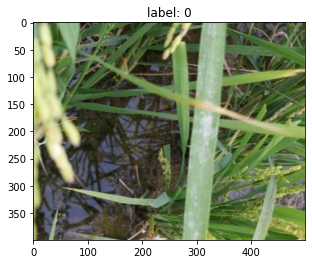

In [14]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

## Transforms

In [15]:
# ====================================================
# transformations
# ====================================================
def get_transforms(*, data):
    if data == 'train':
        return Compose([
            RandomResizedCrop(CFG.size, CFG.size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

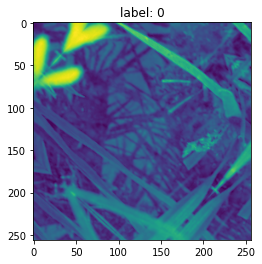

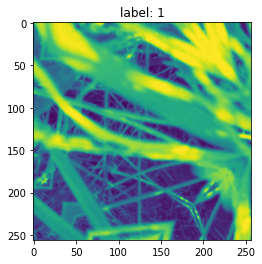

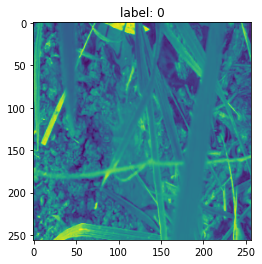

In [16]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(3):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

## MODEL

In [17]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [18]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

In [19]:
# timm.list_models()

In [20]:
# ====================================================
# model initialization
# ====================================================

class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [21]:
model = CustomResNext(model_name = CFG.model_name, pretrained = False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True) # batch_size와 데이터 수에 따라 마지막 Batch의 길이가 달라질 수 있는데 이전에도 말했듯 길이가 다른 Batch는 위험성을 가져옴

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.1498,  0.0821,  0.0883],
        [ 0.0982,  0.0403,  0.0853],
        [ 0.1431,  0.0836, -0.0484],
        [ 0.0129,  0.0573,  0.1488]], grad_fn=<AddmmBackward0>)


In [22]:
# ====================================================
# helper functions
# ====================================================

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0 
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))
        
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}]]'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})'
                  'Elapsed {remain:s}'
                  'Loss: {loss.val:.4f}({loss.avg:.4f})'
                  'Grad: {grad_norm:.4f}'
                  .format(
                  epoch+1, step, len(train_loader), batch_time=batch_time, data_time=data_time, loss=losses,
                  remain=timeSince(start, float(step+1)/len(train_loader)), grad_norm=grad_norm,
                 ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}]'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})'
                  'Elapsed {remain:s}'
                  'Loss: {loss.val:.4f}({loss.avg:.4f})'
                  .format(
                  step, len(valid_loader), batch_time=batch_time, data_time=data_time, loss=losses, remain=timeSince(start, float(step+1)/len(valid_loader)),  
                  ))
        
    # print("preds shape : ",  np.array(preds).shape) #
    predictions = np.concatenate(preds)
    # print("predictions shape : ", predictions.shape) #
    return losses.avg, predictions
    
def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

## Train

In [23]:
# ====================================================
# train loop
# ====================================================

def train_loop(folds, fold):
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    
    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='valid'))
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    def get_scheduler(optimizer):
        if CFG.scheduler == 'ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler
            
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay = CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)
    
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    
    criterion = nn.CrossEntropyLoss()
    
    best_score = 0
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        start_time = time.time()
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
            
        score = get_score(valid_labels, preds.argmax(1))
        
        
        elapsed = time.time() - start_time
        
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 'preds': preds}, OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
            
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    valid_folds[[str(c) for c in range(3)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)
            
    return valid_folds

In [24]:
# ====================================================
# main function
# ====================================================
def main():

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        
    if CFG.inference:
        model = CustomResNext(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        test.loc[:, ["blast", "brown", "healthy"]] = predictions
        test.to_csv("submission.csv", index=False)

In [25]:
if __name__ == '__main__':
    main()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnext50_32x4d_a1h-0146ab0a.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d_a1h-0146ab0a.pth


Epoch: [1][0/133]]Data 0.583 (0.583)Elapsed 0m 8s (remain 18m 21s)Loss: 1.0794(1.0794)Grad: 13.2216
Epoch: [1][100/133]]Data 0.000 (0.006)Elapsed 0m 30s (remain 0m 9s)Loss: 0.9189(0.9542)Grad: 12.4771
Epoch: [1][132/133]]Data 0.000 (0.005)Elapsed 0m 37s (remain 0m 0s)Loss: 0.7329(0.9206)Grad: 13.0745
EVAL: [0/34]Data 0.538 (0.538)Elapsed 0m 0s (remain 0m 19s)Loss: 0.8504(0.8504)


Epoch 1 - avg_train_loss: 0.9206  avg_val_loss: 0.8194  time: 41s
Epoch 1 - Accuracy: 0.6217228464419475
Epoch 1 - Save Best Score: 0.6217 Model


EVAL: [33/34]Data 0.000 (0.056)Elapsed 0m 3s (remain 0m 0s)Loss: 0.9468(0.8194)
Epoch: [2][0/133]]Data 0.495 (0.495)Elapsed 0m 0s (remain 1m 42s)Loss: 1.0522(1.0522)Grad: 14.2388
Epoch: [2][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5985(0.7669)Grad: 11.0748
Epoch: [2][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4698(0.7435)Grad: 8.3460
EVAL: [0/34]Data 0.588 (0.588)Elapsed 0m 0s (remain 0m 22s)Loss: 0.8041(0.8041)


Epoch 2 - avg_train_loss: 0.7435  avg_val_loss: 0.6594  time: 33s
Epoch 2 - Accuracy: 0.7602996254681648
Epoch 2 - Save Best Score: 0.7603 Model


EVAL: [33/34]Data 0.000 (0.044)Elapsed 0m 3s (remain 0m 0s)Loss: 0.9290(0.6594)
Epoch: [3][0/133]]Data 0.533 (0.533)Elapsed 0m 0s (remain 1m 46s)Loss: 0.5377(0.5377)Grad: 9.0726
Epoch: [3][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5067(0.6118)Grad: 13.0088
Epoch: [3][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4884(0.5932)Grad: 9.9115
EVAL: [0/34]Data 0.546 (0.546)Elapsed 0m 0s (remain 0m 22s)Loss: 0.5122(0.5122)


Epoch 3 - avg_train_loss: 0.5932  avg_val_loss: 0.4928  time: 33s
Epoch 3 - Accuracy: 0.8370786516853933
Epoch 3 - Save Best Score: 0.8371 Model


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7236(0.4928)
Epoch: [4][0/133]]Data 0.552 (0.552)Elapsed 0m 0s (remain 1m 47s)Loss: 0.4302(0.4302)Grad: 14.8996
Epoch: [4][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5645(0.5737)Grad: 21.8018
Epoch: [4][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4577(0.5719)Grad: 13.5229
EVAL: [0/34]Data 0.614 (0.614)Elapsed 0m 0s (remain 0m 24s)Loss: 0.5562(0.5562)


Epoch 4 - avg_train_loss: 0.5719  avg_val_loss: 0.4932  time: 34s
Epoch 4 - Accuracy: 0.8183520599250936


EVAL: [33/34]Data 0.000 (0.041)Elapsed 0m 3s (remain 0m 0s)Loss: 1.1824(0.4932)
Epoch: [5][0/133]]Data 0.681 (0.681)Elapsed 0m 1s (remain 2m 33s)Loss: 0.4718(0.4718)Grad: 8.8597
Epoch: [5][100/133]]Data 0.000 (0.007)Elapsed 0m 23s (remain 0m 7s)Loss: 0.3589(0.5002)Grad: 9.8829
Epoch: [5][132/133]]Data 0.000 (0.005)Elapsed 0m 30s (remain 0m 0s)Loss: 0.4966(0.4924)Grad: 11.4230
EVAL: [0/34]Data 0.554 (0.554)Elapsed 0m 0s (remain 0m 20s)Loss: 0.3289(0.3289)


Epoch 5 - avg_train_loss: 0.4924  avg_val_loss: 0.4374  time: 34s
Epoch 5 - Accuracy: 0.8370786516853933


EVAL: [33/34]Data 0.000 (0.039)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7934(0.4374)
Epoch: [6][0/133]]Data 0.459 (0.459)Elapsed 0m 0s (remain 1m 40s)Loss: 0.3918(0.3918)Grad: 11.8891
Epoch: [6][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5876(0.4627)Grad: 17.8731
Epoch: [6][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.8045(0.4658)Grad: 16.4454
EVAL: [0/34]Data 0.549 (0.549)Elapsed 0m 0s (remain 0m 20s)Loss: 0.3320(0.3320)


Epoch 6 - avg_train_loss: 0.4658  avg_val_loss: 0.4010  time: 33s
Epoch 6 - Accuracy: 0.8689138576779026
Epoch 6 - Save Best Score: 0.8689 Model


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7831(0.4010)
Epoch: [7][0/133]]Data 0.459 (0.459)Elapsed 0m 0s (remain 1m 45s)Loss: 0.5684(0.5684)Grad: 12.1750
Epoch: [7][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3531(0.4308)Grad: 10.9068
Epoch: [7][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4949(0.4415)Grad: 12.0697
EVAL: [0/34]Data 0.497 (0.497)Elapsed 0m 0s (remain 0m 19s)Loss: 0.3761(0.3761)


Epoch 7 - avg_train_loss: 0.4415  avg_val_loss: 0.3773  time: 33s
Epoch 7 - Accuracy: 0.8745318352059925
Epoch 7 - Save Best Score: 0.8745 Model


EVAL: [33/34]Data 0.000 (0.037)Elapsed 0m 3s (remain 0m 0s)Loss: 0.9788(0.3773)
Epoch: [8][0/133]]Data 0.548 (0.548)Elapsed 0m 0s (remain 1m 48s)Loss: 0.4274(0.4274)Grad: 29.1730
Epoch: [8][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3241(0.4312)Grad: 9.2545
Epoch: [8][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5233(0.4321)Grad: 16.0472
EVAL: [0/34]Data 0.501 (0.501)Elapsed 0m 0s (remain 0m 18s)Loss: 0.3401(0.3401)


Epoch 8 - avg_train_loss: 0.4321  avg_val_loss: 0.3570  time: 33s
Epoch 8 - Accuracy: 0.8838951310861424
Epoch 8 - Save Best Score: 0.8839 Model


EVAL: [33/34]Data 0.000 (0.036)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8200(0.3570)
Epoch: [9][0/133]]Data 0.833 (0.833)Elapsed 0m 1s (remain 2m 24s)Loss: 0.1743(0.1743)Grad: 6.3237
Epoch: [9][100/133]]Data 0.000 (0.009)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3950(0.4008)Grad: 10.6489
Epoch: [9][132/133]]Data 0.000 (0.007)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1993(0.4031)Grad: 6.8740
EVAL: [0/34]Data 0.536 (0.536)Elapsed 0m 0s (remain 0m 20s)Loss: 0.3504(0.3504)


Epoch 9 - avg_train_loss: 0.4031  avg_val_loss: 0.3571  time: 34s
Epoch 9 - Accuracy: 0.8857677902621723
Epoch 9 - Save Best Score: 0.8858 Model


EVAL: [33/34]Data 0.000 (0.046)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8490(0.3571)
Epoch: [10][0/133]]Data 0.556 (0.556)Elapsed 0m 0s (remain 1m 44s)Loss: 0.2618(0.2618)Grad: 15.9136
Epoch: [10][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2390(0.4106)Grad: 10.2936
Epoch: [10][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4755(0.4078)Grad: 17.2970
EVAL: [0/34]Data 0.861 (0.861)Elapsed 0m 0s (remain 0m 31s)Loss: 0.3517(0.3517)


Epoch 10 - avg_train_loss: 0.4078  avg_val_loss: 0.3553  time: 34s
Epoch 10 - Accuracy: 0.8876404494382022
Epoch 10 - Save Best Score: 0.8876 Model


EVAL: [33/34]Data 0.000 (0.052)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8409(0.3553)
Epoch: [11][0/133]]Data 0.558 (0.558)Elapsed 0m 0s (remain 1m 46s)Loss: 0.5700(0.5700)Grad: 17.4058
Epoch: [11][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5519(0.4233)Grad: 15.1430
Epoch: [11][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4214(0.4182)Grad: 16.1252
EVAL: [0/34]Data 0.536 (0.536)Elapsed 0m 0s (remain 0m 19s)Loss: 0.4002(0.4002)


Epoch 11 - avg_train_loss: 0.4182  avg_val_loss: 0.3907  time: 33s
Epoch 11 - Accuracy: 0.850187265917603


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7179(0.3907)
Epoch: [12][0/133]]Data 0.566 (0.566)Elapsed 0m 0s (remain 1m 49s)Loss: 0.3786(0.3786)Grad: 12.6524
Epoch: [12][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2098(0.3962)Grad: 6.3372
Epoch: [12][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 1.2739(0.4037)Grad: 20.0023
EVAL: [0/34]Data 0.475 (0.475)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1921(0.1921)


Epoch 12 - avg_train_loss: 0.4037  avg_val_loss: 0.3035  time: 33s
Epoch 12 - Accuracy: 0.9026217228464419
Epoch 12 - Save Best Score: 0.9026 Model


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.6839(0.3035)
Epoch: [13][0/133]]Data 0.475 (0.475)Elapsed 0m 0s (remain 1m 37s)Loss: 0.4820(0.4820)Grad: 10.8064
Epoch: [13][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2468(0.3762)Grad: 9.4312
Epoch: [13][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4260(0.3959)Grad: 12.0668
EVAL: [0/34]Data 0.524 (0.524)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2507(0.2507)


Epoch 13 - avg_train_loss: 0.3959  avg_val_loss: 0.2858  time: 33s
Epoch 13 - Accuracy: 0.9138576779026217
Epoch 13 - Save Best Score: 0.9139 Model


EVAL: [33/34]Data 0.000 (0.036)Elapsed 0m 3s (remain 0m 0s)Loss: 0.6418(0.2858)
Epoch: [14][0/133]]Data 0.559 (0.559)Elapsed 0m 0s (remain 1m 51s)Loss: 0.4496(0.4496)Grad: 12.9886
Epoch: [14][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4075(0.3780)Grad: 9.1580
Epoch: [14][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1751(0.3755)Grad: 7.5207
EVAL: [0/34]Data 0.464 (0.464)Elapsed 0m 0s (remain 0m 17s)Loss: 0.2748(0.2748)


Epoch 14 - avg_train_loss: 0.3755  avg_val_loss: 0.2832  time: 33s
Epoch 14 - Accuracy: 0.9026217228464419


EVAL: [33/34]Data 0.000 (0.028)Elapsed 0m 3s (remain 0m 0s)Loss: 0.5411(0.2832)
Epoch: [15][0/133]]Data 0.516 (0.516)Elapsed 0m 0s (remain 1m 46s)Loss: 0.3245(0.3245)Grad: 10.6478
Epoch: [15][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0970(0.3356)Grad: 4.3865
Epoch: [15][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4236(0.3289)Grad: 14.7303
EVAL: [0/34]Data 0.535 (0.535)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1628(0.1628)


Epoch 15 - avg_train_loss: 0.3289  avg_val_loss: 0.2948  time: 33s
Epoch 15 - Accuracy: 0.9063670411985019


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.6483(0.2948)
Epoch: [16][0/133]]Data 0.510 (0.510)Elapsed 0m 0s (remain 1m 40s)Loss: 0.2356(0.2356)Grad: 9.9030
Epoch: [16][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2243(0.3307)Grad: 9.0896
Epoch: [16][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0966(0.3242)Grad: 3.7295
EVAL: [0/34]Data 0.506 (0.506)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1991(0.1991)


Epoch 16 - avg_train_loss: 0.3242  avg_val_loss: 0.2876  time: 33s
Epoch 16 - Accuracy: 0.9044943820224719


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4167(0.2876)
Epoch: [17][0/133]]Data 0.469 (0.469)Elapsed 0m 0s (remain 1m 38s)Loss: 0.2524(0.2524)Grad: 9.2049
Epoch: [17][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2307(0.3051)Grad: 10.9472
Epoch: [17][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1360(0.3016)Grad: 4.4714
EVAL: [0/34]Data 0.517 (0.517)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2078(0.2078)


Epoch 17 - avg_train_loss: 0.3016  avg_val_loss: 0.2724  time: 33s
Epoch 17 - Accuracy: 0.9101123595505618


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.5205(0.2724)
Epoch: [18][0/133]]Data 0.393 (0.393)Elapsed 0m 0s (remain 1m 25s)Loss: 0.2705(0.2705)Grad: 8.4195
Epoch: [18][100/133]]Data 0.000 (0.004)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4904(0.2764)Grad: 10.3538
Epoch: [18][132/133]]Data 0.000 (0.003)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2230(0.2815)Grad: 10.6018
EVAL: [0/34]Data 0.487 (0.487)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1590(0.1590)


Epoch 18 - avg_train_loss: 0.2815  avg_val_loss: 0.2447  time: 33s
Epoch 18 - Accuracy: 0.9157303370786517
Epoch 18 - Save Best Score: 0.9157 Model


EVAL: [33/34]Data 0.000 (0.029)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4064(0.2447)
Epoch: [19][0/133]]Data 0.480 (0.480)Elapsed 0m 0s (remain 1m 40s)Loss: 0.2352(0.2352)Grad: 13.5838
Epoch: [19][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2541(0.2769)Grad: 7.5124
Epoch: [19][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1620(0.2805)Grad: 8.0647
EVAL: [0/34]Data 0.421 (0.421)Elapsed 0m 0s (remain 0m 16s)Loss: 0.2036(0.2036)


Epoch 19 - avg_train_loss: 0.2805  avg_val_loss: 0.2205  time: 33s
Epoch 19 - Accuracy: 0.9213483146067416
Epoch 19 - Save Best Score: 0.9213 Model


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4457(0.2205)
Epoch: [20][0/133]]Data 0.445 (0.445)Elapsed 0m 0s (remain 1m 36s)Loss: 0.3601(0.3601)Grad: 10.1376
Epoch: [20][100/133]]Data 0.011 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.7210(0.2813)Grad: 17.9092
Epoch: [20][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3887(0.2841)Grad: 12.5851
EVAL: [0/34]Data 0.478 (0.478)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1698(0.1698)


Epoch 20 - avg_train_loss: 0.2841  avg_val_loss: 0.2341  time: 33s
Epoch 20 - Accuracy: 0.9213483146067416


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4949(0.2341)
Epoch: [21][0/133]]Data 0.531 (0.531)Elapsed 0m 0s (remain 1m 46s)Loss: 0.3125(0.3125)Grad: 8.7464
Epoch: [21][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2029(0.3076)Grad: 9.8891
Epoch: [21][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5173(0.3103)Grad: 13.5126
EVAL: [0/34]Data 0.577 (0.577)Elapsed 0m 0s (remain 0m 20s)Loss: 0.3389(0.3389)


Epoch 21 - avg_train_loss: 0.3103  avg_val_loss: 0.2369  time: 33s
Epoch 21 - Accuracy: 0.9288389513108615
Epoch 21 - Save Best Score: 0.9288 Model


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8383(0.2369)
Epoch: [22][0/133]]Data 0.526 (0.526)Elapsed 0m 0s (remain 1m 45s)Loss: 0.2037(0.2037)Grad: 9.0356
Epoch: [22][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1290(0.2902)Grad: 6.6658
Epoch: [22][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1687(0.2953)Grad: 7.8990
EVAL: [0/34]Data 0.501 (0.501)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1448(0.1448)


Epoch 22 - avg_train_loss: 0.2953  avg_val_loss: 0.2314  time: 33s
Epoch 22 - Accuracy: 0.9176029962546817


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.6527(0.2314)
Epoch: [23][0/133]]Data 0.534 (0.534)Elapsed 0m 0s (remain 1m 52s)Loss: 0.4811(0.4811)Grad: 15.5334
Epoch: [23][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1514(0.2752)Grad: 6.5225
Epoch: [23][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1714(0.2754)Grad: 7.8930
EVAL: [0/34]Data 0.469 (0.469)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2269(0.2269)


Epoch 23 - avg_train_loss: 0.2754  avg_val_loss: 0.2156  time: 33s
Epoch 23 - Accuracy: 0.9325842696629213
Epoch 23 - Save Best Score: 0.9326 Model


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.5218(0.2156)
Epoch: [24][0/133]]Data 0.525 (0.525)Elapsed 0m 0s (remain 1m 43s)Loss: 0.2129(0.2129)Grad: 8.4473
Epoch: [24][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0870(0.2993)Grad: 5.0835
Epoch: [24][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1783(0.3011)Grad: 9.1005
EVAL: [0/34]Data 0.470 (0.470)Elapsed 0m 0s (remain 0m 17s)Loss: 0.1882(0.1882)


Epoch 24 - avg_train_loss: 0.3011  avg_val_loss: 0.1968  time: 33s
Epoch 24 - Accuracy: 0.9419475655430711
Epoch 24 - Save Best Score: 0.9419 Model


EVAL: [33/34]Data 0.000 (0.037)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7977(0.1968)
Epoch: [25][0/133]]Data 0.554 (0.554)Elapsed 0m 0s (remain 1m 47s)Loss: 0.2853(0.2853)Grad: 8.5979
Epoch: [25][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2943(0.2620)Grad: 10.6559
Epoch: [25][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2318(0.2476)Grad: 7.4976
EVAL: [0/34]Data 0.512 (0.512)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2735(0.2735)


Epoch 25 - avg_train_loss: 0.2476  avg_val_loss: 0.2143  time: 33s
Epoch 25 - Accuracy: 0.9344569288389513


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8868(0.2143)
Epoch: [26][0/133]]Data 0.521 (0.521)Elapsed 0m 0s (remain 1m 48s)Loss: 0.1141(0.1141)Grad: 4.9514
Epoch: [26][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0816(0.2502)Grad: 5.3392
Epoch: [26][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1953(0.2495)Grad: 8.2234
EVAL: [0/34]Data 0.443 (0.443)Elapsed 0m 0s (remain 0m 17s)Loss: 0.2345(0.2345)


Epoch 26 - avg_train_loss: 0.2495  avg_val_loss: 0.2006  time: 33s
Epoch 26 - Accuracy: 0.9363295880149812


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 1.0322(0.2006)
Epoch: [27][0/133]]Data 0.480 (0.480)Elapsed 0m 0s (remain 1m 44s)Loss: 0.0933(0.0933)Grad: 5.4901
Epoch: [27][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1236(0.2387)Grad: 7.3327
Epoch: [27][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1661(0.2273)Grad: 7.9818
EVAL: [0/34]Data 0.462 (0.462)Elapsed 0m 0s (remain 0m 18s)Loss: 0.2571(0.2571)


Epoch 27 - avg_train_loss: 0.2273  avg_val_loss: 0.2011  time: 33s
Epoch 27 - Accuracy: 0.9400749063670412


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.9607(0.2011)
Epoch: [28][0/133]]Data 0.505 (0.505)Elapsed 0m 0s (remain 1m 44s)Loss: 0.3268(0.3268)Grad: 11.4011
Epoch: [28][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1442(0.2556)Grad: 7.7281
Epoch: [28][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0535(0.2459)Grad: 3.2973
EVAL: [0/34]Data 0.554 (0.554)Elapsed 0m 0s (remain 0m 20s)Loss: 0.2193(0.2193)


Epoch 28 - avg_train_loss: 0.2459  avg_val_loss: 0.1946  time: 33s
Epoch 28 - Accuracy: 0.9344569288389513


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8461(0.1946)
Epoch: [29][0/133]]Data 0.545 (0.545)Elapsed 0m 0s (remain 1m 50s)Loss: 0.1093(0.1093)Grad: 5.1378
Epoch: [29][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1261(0.2184)Grad: 5.2600
Epoch: [29][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2425(0.2114)Grad: 8.9747
EVAL: [0/34]Data 0.495 (0.495)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2062(0.2062)


Epoch 29 - avg_train_loss: 0.2114  avg_val_loss: 0.1848  time: 33s
Epoch 29 - Accuracy: 0.9438202247191011
Epoch 29 - Save Best Score: 0.9438 Model


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7318(0.1848)
Epoch: [30][0/133]]Data 0.515 (0.515)Elapsed 0m 0s (remain 1m 43s)Loss: 0.5130(0.5130)Grad: 11.8839
Epoch: [30][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3099(0.2234)Grad: 14.8216
Epoch: [30][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2278(0.2225)Grad: 13.1161
EVAL: [0/34]Data 0.685 (0.685)Elapsed 0m 0s (remain 0m 29s)Loss: 0.1901(0.1901)


Epoch 30 - avg_train_loss: 0.2225  avg_val_loss: 0.1924  time: 33s
Epoch 30 - Accuracy: 0.9382022471910112


EVAL: [33/34]Data 0.000 (0.037)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7929(0.1924)
Epoch: [31][0/133]]Data 0.546 (0.546)Elapsed 0m 0s (remain 1m 45s)Loss: 0.1690(0.1690)Grad: 6.9221
Epoch: [31][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1935(0.2395)Grad: 7.6818
Epoch: [31][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1054(0.2521)Grad: 5.0470
EVAL: [0/34]Data 0.423 (0.423)Elapsed 0m 0s (remain 0m 16s)Loss: 0.1410(0.1410)


Epoch 31 - avg_train_loss: 0.2521  avg_val_loss: 0.1930  time: 33s
Epoch 31 - Accuracy: 0.9419475655430711


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 1.2321(0.1930)
Epoch: [32][0/133]]Data 0.506 (0.506)Elapsed 0m 0s (remain 1m 39s)Loss: 0.2135(0.2135)Grad: 9.4227
Epoch: [32][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1380(0.2339)Grad: 7.3608
Epoch: [32][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2690(0.2371)Grad: 11.1310
EVAL: [0/34]Data 0.411 (0.411)Elapsed 0m 0s (remain 0m 15s)Loss: 0.1846(0.1846)


Epoch 32 - avg_train_loss: 0.2371  avg_val_loss: 0.1799  time: 33s
Epoch 32 - Accuracy: 0.9419475655430711


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 1.7040(0.1799)
Epoch: [33][0/133]]Data 0.560 (0.560)Elapsed 0m 0s (remain 1m 48s)Loss: 0.2717(0.2717)Grad: 8.8914
Epoch: [33][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2713(0.2647)Grad: 8.6126
Epoch: [33][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1414(0.2547)Grad: 7.9165
EVAL: [0/34]Data 0.551 (0.551)Elapsed 0m 0s (remain 0m 20s)Loss: 0.1635(0.1635)


Epoch 33 - avg_train_loss: 0.2547  avg_val_loss: 0.1950  time: 33s
Epoch 33 - Accuracy: 0.9288389513108615


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7963(0.1950)
Epoch: [34][0/133]]Data 0.569 (0.569)Elapsed 0m 0s (remain 1m 48s)Loss: 0.1996(0.1996)Grad: 7.4392
Epoch: [34][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3627(0.2295)Grad: 13.7259
Epoch: [34][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0839(0.2301)Grad: 3.6286
EVAL: [0/34]Data 0.719 (0.719)Elapsed 0m 0s (remain 0m 26s)Loss: 0.1043(0.1043)


Epoch 34 - avg_train_loss: 0.2301  avg_val_loss: 0.1609  time: 33s
Epoch 34 - Accuracy: 0.947565543071161
Epoch 34 - Save Best Score: 0.9476 Model


EVAL: [33/34]Data 0.000 (0.037)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7505(0.1609)
Epoch: [35][0/133]]Data 0.571 (0.571)Elapsed 0m 0s (remain 1m 49s)Loss: 0.0270(0.0270)Grad: 1.7362
Epoch: [35][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1583(0.2192)Grad: 5.6253
Epoch: [35][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2843(0.2103)Grad: 14.8516
EVAL: [0/34]Data 0.513 (0.513)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1341(0.1341)


Epoch 35 - avg_train_loss: 0.2103  avg_val_loss: 0.1795  time: 33s
Epoch 35 - Accuracy: 0.9382022471910112


EVAL: [33/34]Data 0.000 (0.025)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4203(0.1795)
Epoch: [36][0/133]]Data 0.493 (0.493)Elapsed 0m 0s (remain 1m 39s)Loss: 0.1301(0.1301)Grad: 7.2475
Epoch: [36][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5150(0.2073)Grad: 14.2415
Epoch: [36][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2160(0.2080)Grad: 7.6713
EVAL: [0/34]Data 0.467 (0.467)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0669(0.0669)


Epoch 36 - avg_train_loss: 0.2080  avg_val_loss: 0.1745  time: 33s
Epoch 36 - Accuracy: 0.9456928838951311


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 1.2384(0.1745)
Epoch: [37][0/133]]Data 0.596 (0.596)Elapsed 0m 0s (remain 1m 50s)Loss: 0.7651(0.7651)Grad: 19.9727
Epoch: [37][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0372(0.2148)Grad: 2.8155
Epoch: [37][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1308(0.2100)Grad: 6.3198
EVAL: [0/34]Data 0.512 (0.512)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0770(0.0770)


Epoch 37 - avg_train_loss: 0.2100  avg_val_loss: 0.1534  time: 33s
Epoch 37 - Accuracy: 0.9531835205992509
Epoch 37 - Save Best Score: 0.9532 Model


EVAL: [33/34]Data 0.000 (0.029)Elapsed 0m 3s (remain 0m 0s)Loss: 1.0108(0.1534)
Epoch: [38][0/133]]Data 0.494 (0.494)Elapsed 0m 0s (remain 1m 46s)Loss: 0.1119(0.1119)Grad: 4.8227
Epoch: [38][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1732(0.1852)Grad: 6.8651
Epoch: [38][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4776(0.1900)Grad: 13.7341
EVAL: [0/34]Data 0.520 (0.520)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1182(0.1182)


Epoch 38 - avg_train_loss: 0.1900  avg_val_loss: 0.1607  time: 33s
Epoch 38 - Accuracy: 0.951310861423221


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8782(0.1607)
Epoch: [39][0/133]]Data 0.516 (0.516)Elapsed 0m 0s (remain 1m 42s)Loss: 0.2197(0.2197)Grad: 7.8920
Epoch: [39][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3205(0.1609)Grad: 11.6451
Epoch: [39][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1350(0.1665)Grad: 5.2009
EVAL: [0/34]Data 0.564 (0.564)Elapsed 0m 0s (remain 0m 20s)Loss: 0.1962(0.1962)


Epoch 39 - avg_train_loss: 0.1665  avg_val_loss: 0.1579  time: 33s
Epoch 39 - Accuracy: 0.9400749063670412


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 1.4272(0.1579)
Epoch: [40][0/133]]Data 0.599 (0.599)Elapsed 0m 0s (remain 1m 52s)Loss: 0.2431(0.2431)Grad: 12.8305
Epoch: [40][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4321(0.1779)Grad: 13.7717
Epoch: [40][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1332(0.1888)Grad: 5.1511
EVAL: [0/34]Data 0.541 (0.541)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1281(0.1281)


Epoch 40 - avg_train_loss: 0.1888  avg_val_loss: 0.1482  time: 33s
Epoch 40 - Accuracy: 0.949438202247191


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 1.2821(0.1482)
Epoch: [41][0/133]]Data 0.581 (0.581)Elapsed 0m 0s (remain 1m 50s)Loss: 0.1078(0.1078)Grad: 5.2729
Epoch: [41][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0953(0.2073)Grad: 4.5492
Epoch: [41][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1725(0.2005)Grad: 7.9682
EVAL: [0/34]Data 0.504 (0.504)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1235(0.1235)


Epoch 41 - avg_train_loss: 0.2005  avg_val_loss: 0.1794  time: 33s
Epoch 41 - Accuracy: 0.9400749063670412


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 1.7005(0.1794)
Epoch: [42][0/133]]Data 0.578 (0.578)Elapsed 0m 0s (remain 1m 47s)Loss: 0.3525(0.3525)Grad: 14.5101
Epoch: [42][100/133]]Data 0.001 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2965(0.2086)Grad: 11.5971
Epoch: [42][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2798(0.2024)Grad: 8.3844
EVAL: [0/34]Data 0.468 (0.468)Elapsed 0m 0s (remain 0m 17s)Loss: 0.2656(0.2656)


Epoch 42 - avg_train_loss: 0.2024  avg_val_loss: 0.1894  time: 33s
Epoch 42 - Accuracy: 0.9269662921348315


EVAL: [33/34]Data 0.000 (0.028)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8830(0.1894)
Epoch: [43][0/133]]Data 0.481 (0.481)Elapsed 0m 0s (remain 1m 42s)Loss: 0.1043(0.1043)Grad: 5.4461
Epoch: [43][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0919(0.2122)Grad: 3.7934
Epoch: [43][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0418(0.2124)Grad: 2.4997
EVAL: [0/34]Data 0.468 (0.468)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1488(0.1488)


Epoch 43 - avg_train_loss: 0.2124  avg_val_loss: 0.1737  time: 33s
Epoch 43 - Accuracy: 0.9550561797752809
Epoch 43 - Save Best Score: 0.9551 Model


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 1.3176(0.1737)
Epoch: [44][0/133]]Data 0.803 (0.803)Elapsed 0m 1s (remain 2m 29s)Loss: 0.2260(0.2260)Grad: 9.6972
Epoch: [44][100/133]]Data 0.000 (0.008)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2994(0.1986)Grad: 9.6569
Epoch: [44][132/133]]Data 0.000 (0.006)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1241(0.2007)Grad: 5.8983
EVAL: [0/34]Data 0.437 (0.437)Elapsed 0m 0s (remain 0m 16s)Loss: 0.1196(0.1196)


Epoch 44 - avg_train_loss: 0.2007  avg_val_loss: 0.1843  time: 33s
Epoch 44 - Accuracy: 0.9569288389513109
Epoch 44 - Save Best Score: 0.9569 Model


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7793(0.1843)
Epoch: [45][0/133]]Data 0.822 (0.822)Elapsed 0m 1s (remain 2m 58s)Loss: 0.0883(0.0883)Grad: 5.0475
Epoch: [45][100/133]]Data 0.001 (0.008)Elapsed 0m 23s (remain 0m 7s)Loss: 0.2407(0.1751)Grad: 11.2786
Epoch: [45][132/133]]Data 0.000 (0.006)Elapsed 0m 30s (remain 0m 0s)Loss: 0.0646(0.1851)Grad: 3.2658
EVAL: [0/34]Data 0.490 (0.490)Elapsed 0m 0s (remain 0m 17s)Loss: 0.1718(0.1718)


Epoch 45 - avg_train_loss: 0.1851  avg_val_loss: 0.1972  time: 33s
Epoch 45 - Accuracy: 0.9438202247191011


EVAL: [33/34]Data 0.000 (0.036)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8639(0.1972)
Epoch: [46][0/133]]Data 0.685 (0.685)Elapsed 0m 0s (remain 2m 11s)Loss: 0.2128(0.2128)Grad: 7.7424
Epoch: [46][100/133]]Data 0.001 (0.007)Elapsed 0m 23s (remain 0m 7s)Loss: 0.0528(0.1875)Grad: 3.2646
Epoch: [46][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2722(0.1837)Grad: 9.6428
EVAL: [0/34]Data 0.496 (0.496)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1743(0.1743)


Epoch 46 - avg_train_loss: 0.1837  avg_val_loss: 0.2000  time: 33s
Epoch 46 - Accuracy: 0.947565543071161


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.9083(0.2000)
Epoch: [47][0/133]]Data 0.697 (0.697)Elapsed 0m 0s (remain 2m 9s)Loss: 0.0435(0.0435)Grad: 2.9906
Epoch: [47][100/133]]Data 0.001 (0.007)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1581(0.1565)Grad: 9.0640
Epoch: [47][132/133]]Data 0.000 (0.006)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1215(0.1617)Grad: 8.5566
EVAL: [0/34]Data 0.443 (0.443)Elapsed 0m 0s (remain 0m 17s)Loss: 0.1687(0.1687)


Epoch 47 - avg_train_loss: 0.1617  avg_val_loss: 0.2226  time: 33s
Epoch 47 - Accuracy: 0.9400749063670412


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7595(0.2226)
Epoch: [48][0/133]]Data 0.631 (0.631)Elapsed 0m 0s (remain 2m 2s)Loss: 0.1148(0.1148)Grad: 5.8499
Epoch: [48][100/133]]Data 0.000 (0.007)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1352(0.1689)Grad: 6.7322
Epoch: [48][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0455(0.1610)Grad: 2.2271
EVAL: [0/34]Data 0.485 (0.485)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1373(0.1373)


Epoch 48 - avg_train_loss: 0.1610  avg_val_loss: 0.1793  time: 33s
Epoch 48 - Accuracy: 0.951310861423221


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 1.2543(0.1793)
Epoch: [49][0/133]]Data 0.580 (0.580)Elapsed 0m 0s (remain 1m 51s)Loss: 0.7097(0.7097)Grad: 17.0190
Epoch: [49][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1530(0.1588)Grad: 6.8986
Epoch: [49][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0971(0.1644)Grad: 4.2959
EVAL: [0/34]Data 0.435 (0.435)Elapsed 0m 0s (remain 0m 16s)Loss: 0.1205(0.1205)
EVAL: [33/34]Data 0.000 (0.036)Elapsed 0m 3s (remain 0m 0s)Loss: 1.2025(0.1838)


Epoch 49 - avg_train_loss: 0.1644  avg_val_loss: 0.1838  time: 33s
Epoch 49 - Accuracy: 0.9569288389513109


Epoch: [50][0/133]]Data 0.764 (0.764)Elapsed 0m 1s (remain 2m 17s)Loss: 0.0988(0.0988)Grad: 5.3850
Epoch: [50][100/133]]Data 0.000 (0.008)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1244(0.1496)Grad: 5.5991
Epoch: [50][132/133]]Data 0.000 (0.006)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1171(0.1504)Grad: 6.3897
EVAL: [0/34]Data 0.451 (0.451)Elapsed 0m 0s (remain 0m 18s)Loss: 0.2014(0.2014)


Epoch 50 - avg_train_loss: 0.1504  avg_val_loss: 0.1906  time: 34s
Epoch 50 - Accuracy: 0.951310861423221


EVAL: [33/34]Data 0.000 (0.048)Elapsed 0m 4s (remain 0m 0s)Loss: 1.2525(0.1906)


========== fold: 0 result ==========
Score: 0.95693


Epoch: [1][0/133]]Data 0.554 (0.554)Elapsed 0m 0s (remain 1m 46s)Loss: 1.0945(1.0945)Grad: 14.4618
Epoch: [1][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.9634(0.9404)Grad: 15.6634
Epoch: [1][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.7107(0.9309)Grad: 7.5785
EVAL: [0/34]Data 0.821 (0.821)Elapsed 0m 0s (remain 0m 29s)Loss: 0.7623(0.7623)


Epoch 1 - avg_train_loss: 0.9309  avg_val_loss: 0.8083  time: 34s
Epoch 1 - Accuracy: 0.6985018726591761
Epoch 1 - Save Best Score: 0.6985 Model


EVAL: [33/34]Data 0.000 (0.048)Elapsed 0m 4s (remain 0m 0s)Loss: 0.9015(0.8083)
Epoch: [2][0/133]]Data 0.605 (0.605)Elapsed 0m 0s (remain 1m 51s)Loss: 0.9067(0.9067)Grad: 8.7556
Epoch: [2][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5784(0.7573)Grad: 7.3686
Epoch: [2][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5884(0.7420)Grad: 9.7023
EVAL: [0/34]Data 0.648 (0.648)Elapsed 0m 0s (remain 0m 24s)Loss: 0.6463(0.6463)


Epoch 2 - avg_train_loss: 0.7420  avg_val_loss: 0.6469  time: 33s
Epoch 2 - Accuracy: 0.7434456928838952
Epoch 2 - Save Best Score: 0.7434 Model


EVAL: [33/34]Data 0.000 (0.040)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7227(0.6469)
Epoch: [3][0/133]]Data 0.566 (0.566)Elapsed 0m 0s (remain 1m 50s)Loss: 0.5799(0.5799)Grad: 10.7716
Epoch: [3][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.8812(0.6103)Grad: 19.8359
Epoch: [3][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4114(0.6048)Grad: 8.8880
EVAL: [0/34]Data 0.558 (0.558)Elapsed 0m 0s (remain 0m 21s)Loss: 0.4611(0.4611)


Epoch 3 - avg_train_loss: 0.6048  avg_val_loss: 0.4688  time: 33s
Epoch 3 - Accuracy: 0.8202247191011236
Epoch 3 - Save Best Score: 0.8202 Model


EVAL: [33/34]Data 0.000 (0.038)Elapsed 0m 3s (remain 0m 0s)Loss: 0.6391(0.4688)
Epoch: [4][0/133]]Data 0.539 (0.539)Elapsed 0m 0s (remain 1m 45s)Loss: 0.4335(0.4335)Grad: 9.2609
Epoch: [4][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4217(0.5381)Grad: 12.8471
Epoch: [4][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5978(0.5429)Grad: 13.9698
EVAL: [0/34]Data 0.491 (0.491)Elapsed 0m 0s (remain 0m 18s)Loss: 0.3124(0.3124)


Epoch 4 - avg_train_loss: 0.5429  avg_val_loss: 0.3971  time: 33s
Epoch 4 - Accuracy: 0.8576779026217228
Epoch 4 - Save Best Score: 0.8577 Model


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3479(0.3971)
Epoch: [5][0/133]]Data 0.570 (0.570)Elapsed 0m 0s (remain 1m 46s)Loss: 0.4035(0.4035)Grad: 10.8200
Epoch: [5][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5338(0.4787)Grad: 24.7573
Epoch: [5][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.6229(0.4717)Grad: 12.7832
EVAL: [0/34]Data 0.475 (0.475)Elapsed 0m 0s (remain 0m 18s)Loss: 0.3199(0.3199)


Epoch 5 - avg_train_loss: 0.4717  avg_val_loss: 0.3732  time: 33s
Epoch 5 - Accuracy: 0.8707865168539326
Epoch 5 - Save Best Score: 0.8708 Model


EVAL: [33/34]Data 0.000 (0.026)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3631(0.3732)
Epoch: [6][0/133]]Data 0.488 (0.488)Elapsed 0m 0s (remain 1m 43s)Loss: 0.3302(0.3302)Grad: 9.4966
Epoch: [6][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4426(0.4719)Grad: 13.8896
Epoch: [6][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3168(0.4730)Grad: 9.1418
EVAL: [0/34]Data 0.558 (0.558)Elapsed 0m 0s (remain 0m 20s)Loss: 0.2455(0.2455)


Epoch 6 - avg_train_loss: 0.4730  avg_val_loss: 0.3430  time: 33s
Epoch 6 - Accuracy: 0.8932584269662921
Epoch 6 - Save Best Score: 0.8933 Model


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3247(0.3430)
Epoch: [7][0/133]]Data 0.549 (0.549)Elapsed 0m 0s (remain 1m 48s)Loss: 0.3403(0.3403)Grad: 7.4595
Epoch: [7][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4646(0.4347)Grad: 11.3503
Epoch: [7][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3791(0.4360)Grad: 17.4410
EVAL: [0/34]Data 0.511 (0.511)Elapsed 0m 0s (remain 0m 18s)Loss: 0.2573(0.2573)


Epoch 7 - avg_train_loss: 0.4360  avg_val_loss: 0.3213  time: 33s
Epoch 7 - Accuracy: 0.8951310861423221
Epoch 7 - Save Best Score: 0.8951 Model


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2549(0.3213)
Epoch: [8][0/133]]Data 0.567 (0.567)Elapsed 0m 0s (remain 1m 48s)Loss: 0.2386(0.2386)Grad: 7.0560
Epoch: [8][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2204(0.4134)Grad: 6.4862
Epoch: [8][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4125(0.4106)Grad: 11.4701
EVAL: [0/34]Data 0.523 (0.523)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2660(0.2660)


Epoch 8 - avg_train_loss: 0.4106  avg_val_loss: 0.3158  time: 33s
Epoch 8 - Accuracy: 0.897003745318352
Epoch 8 - Save Best Score: 0.8970 Model


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2716(0.3158)
Epoch: [9][0/133]]Data 0.485 (0.485)Elapsed 0m 0s (remain 1m 46s)Loss: 0.3409(0.3409)Grad: 13.8486
Epoch: [9][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2803(0.3948)Grad: 9.4697
Epoch: [9][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.7103(0.3950)Grad: 16.0377
EVAL: [0/34]Data 0.489 (0.489)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2712(0.2712)


Epoch 9 - avg_train_loss: 0.3950  avg_val_loss: 0.3161  time: 33s
Epoch 9 - Accuracy: 0.8913857677902621


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2109(0.3161)
Epoch: [10][0/133]]Data 0.551 (0.551)Elapsed 0m 0s (remain 1m 46s)Loss: 0.2791(0.2791)Grad: 11.9039
Epoch: [10][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2333(0.3818)Grad: 10.5646
Epoch: [10][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4957(0.4100)Grad: 20.0287
EVAL: [0/34]Data 0.403 (0.403)Elapsed 0m 0s (remain 0m 15s)Loss: 0.2391(0.2391)


Epoch 10 - avg_train_loss: 0.4100  avg_val_loss: 0.3097  time: 33s
Epoch 10 - Accuracy: 0.8932584269662921


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2802(0.3097)
Epoch: [11][0/133]]Data 0.573 (0.573)Elapsed 0m 0s (remain 1m 53s)Loss: 0.4346(0.4346)Grad: 15.9862
Epoch: [11][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.7207(0.4283)Grad: 19.9306
Epoch: [11][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1468(0.4141)Grad: 7.4022
EVAL: [0/34]Data 0.521 (0.521)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2675(0.2675)


Epoch 11 - avg_train_loss: 0.4141  avg_val_loss: 0.3638  time: 33s
Epoch 11 - Accuracy: 0.8782771535580525


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1091(0.3638)
Epoch: [12][0/133]]Data 0.585 (0.585)Elapsed 0m 0s (remain 1m 53s)Loss: 0.2129(0.2129)Grad: 8.0141
Epoch: [12][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3012(0.3742)Grad: 13.5136
Epoch: [12][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5307(0.3850)Grad: 20.5680
EVAL: [0/34]Data 0.545 (0.545)Elapsed 0m 0s (remain 0m 20s)Loss: 0.2877(0.2877)


Epoch 12 - avg_train_loss: 0.3850  avg_val_loss: 0.3308  time: 33s
Epoch 12 - Accuracy: 0.8895131086142322


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1673(0.3308)
Epoch: [13][0/133]]Data 0.453 (0.453)Elapsed 0m 0s (remain 1m 37s)Loss: 0.4160(0.4160)Grad: 17.1434
Epoch: [13][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3526(0.4052)Grad: 12.1424
Epoch: [13][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3045(0.4011)Grad: 8.3036
EVAL: [0/34]Data 0.540 (0.540)Elapsed 0m 0s (remain 0m 20s)Loss: 0.4143(0.4143)


Epoch 13 - avg_train_loss: 0.4011  avg_val_loss: 0.2929  time: 33s
Epoch 13 - Accuracy: 0.9044943820224719
Epoch 13 - Save Best Score: 0.9045 Model


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0909(0.2929)
Epoch: [14][0/133]]Data 0.516 (0.516)Elapsed 0m 0s (remain 1m 47s)Loss: 0.2990(0.2990)Grad: 9.3919
Epoch: [14][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.8376(0.4015)Grad: 18.4710
Epoch: [14][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4338(0.3902)Grad: 18.2690
EVAL: [0/34]Data 0.513 (0.513)Elapsed 0m 0s (remain 0m 20s)Loss: 0.3107(0.3107)


Epoch 14 - avg_train_loss: 0.3902  avg_val_loss: 0.2925  time: 33s
Epoch 14 - Accuracy: 0.9026217228464419


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0436(0.2925)
Epoch: [15][0/133]]Data 0.490 (0.490)Elapsed 0m 0s (remain 1m 38s)Loss: 0.2244(0.2244)Grad: 11.9868
Epoch: [15][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4339(0.3341)Grad: 14.0283
Epoch: [15][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2433(0.3325)Grad: 10.0724
EVAL: [0/34]Data 0.469 (0.469)Elapsed 0m 0s (remain 0m 18s)Loss: 0.3301(0.3301)


Epoch 15 - avg_train_loss: 0.3325  avg_val_loss: 0.2786  time: 33s
Epoch 15 - Accuracy: 0.9026217228464419


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0474(0.2786)
Epoch: [16][0/133]]Data 0.554 (0.554)Elapsed 0m 0s (remain 1m 46s)Loss: 0.1671(0.1671)Grad: 11.0916
Epoch: [16][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1593(0.3270)Grad: 7.1045
Epoch: [16][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2887(0.3248)Grad: 14.3720
EVAL: [0/34]Data 0.466 (0.466)Elapsed 0m 0s (remain 0m 18s)Loss: 0.2718(0.2718)


Epoch 16 - avg_train_loss: 0.3248  avg_val_loss: 0.2447  time: 33s
Epoch 16 - Accuracy: 0.9082397003745318
Epoch 16 - Save Best Score: 0.9082 Model


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0323(0.2447)
Epoch: [17][0/133]]Data 0.527 (0.527)Elapsed 0m 0s (remain 1m 45s)Loss: 0.5709(0.5709)Grad: 17.7855
Epoch: [17][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2664(0.3126)Grad: 14.7487
Epoch: [17][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3350(0.3103)Grad: 11.4768
EVAL: [0/34]Data 0.507 (0.507)Elapsed 0m 0s (remain 0m 18s)Loss: 0.3426(0.3426)


Epoch 17 - avg_train_loss: 0.3103  avg_val_loss: 0.2367  time: 33s
Epoch 17 - Accuracy: 0.9176029962546817
Epoch 17 - Save Best Score: 0.9176 Model


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0632(0.2367)
Epoch: [18][0/133]]Data 0.580 (0.580)Elapsed 0m 0s (remain 1m 53s)Loss: 0.6497(0.6497)Grad: 22.2179
Epoch: [18][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1230(0.2806)Grad: 6.7736
Epoch: [18][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2325(0.2781)Grad: 9.6679
EVAL: [0/34]Data 0.519 (0.519)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2847(0.2847)


Epoch 18 - avg_train_loss: 0.2781  avg_val_loss: 0.2316  time: 33s
Epoch 18 - Accuracy: 0.9157303370786517


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0744(0.2316)
Epoch: [19][0/133]]Data 0.561 (0.561)Elapsed 0m 0s (remain 1m 47s)Loss: 0.7226(0.7226)Grad: 20.2336
Epoch: [19][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0950(0.3093)Grad: 10.4502
Epoch: [19][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2967(0.3004)Grad: 13.4772
EVAL: [0/34]Data 0.567 (0.567)Elapsed 0m 0s (remain 0m 21s)Loss: 0.3022(0.3022)


Epoch 19 - avg_train_loss: 0.3004  avg_val_loss: 0.2256  time: 33s
Epoch 19 - Accuracy: 0.9176029962546817


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0564(0.2256)
Epoch: [20][0/133]]Data 0.586 (0.586)Elapsed 0m 0s (remain 1m 50s)Loss: 0.1200(0.1200)Grad: 7.2885
Epoch: [20][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1728(0.2659)Grad: 9.0539
Epoch: [20][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2938(0.2742)Grad: 11.8507
EVAL: [0/34]Data 0.474 (0.474)Elapsed 0m 0s (remain 0m 18s)Loss: 0.3295(0.3295)


Epoch 20 - avg_train_loss: 0.2742  avg_val_loss: 0.2239  time: 33s
Epoch 20 - Accuracy: 0.9232209737827716
Epoch 20 - Save Best Score: 0.9232 Model


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0506(0.2239)
Epoch: [21][0/133]]Data 0.569 (0.569)Elapsed 0m 0s (remain 1m 44s)Loss: 0.3598(0.3598)Grad: 15.5388
Epoch: [21][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2313(0.2902)Grad: 9.1513
Epoch: [21][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1182(0.2958)Grad: 7.4729
EVAL: [0/34]Data 0.495 (0.495)Elapsed 0m 0s (remain 0m 18s)Loss: 0.2293(0.2293)


Epoch 21 - avg_train_loss: 0.2958  avg_val_loss: 0.2338  time: 33s
Epoch 21 - Accuracy: 0.9063670411985019


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0309(0.2338)
Epoch: [22][0/133]]Data 0.538 (0.538)Elapsed 0m 0s (remain 1m 44s)Loss: 0.1808(0.1808)Grad: 7.9258
Epoch: [22][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1289(0.2794)Grad: 8.0474
Epoch: [22][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5442(0.2796)Grad: 18.7832
EVAL: [0/34]Data 0.464 (0.464)Elapsed 0m 0s (remain 0m 18s)Loss: 0.3184(0.3184)


Epoch 22 - avg_train_loss: 0.2796  avg_val_loss: 0.2725  time: 33s
Epoch 22 - Accuracy: 0.898876404494382


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0747(0.2725)
Epoch: [23][0/133]]Data 0.526 (0.526)Elapsed 0m 0s (remain 1m 50s)Loss: 0.3069(0.3069)Grad: 11.8444
Epoch: [23][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1562(0.2970)Grad: 8.6602
Epoch: [23][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3385(0.2895)Grad: 9.4938
EVAL: [0/34]Data 0.481 (0.481)Elapsed 0m 0s (remain 0m 18s)Loss: 0.2494(0.2494)


Epoch 23 - avg_train_loss: 0.2895  avg_val_loss: 0.2734  time: 33s
Epoch 23 - Accuracy: 0.9250936329588015
Epoch 23 - Save Best Score: 0.9251 Model


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0170(0.2734)
Epoch: [24][0/133]]Data 0.501 (0.501)Elapsed 0m 0s (remain 1m 42s)Loss: 0.3001(0.3001)Grad: 14.8408
Epoch: [24][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0346(0.2720)Grad: 1.7944
Epoch: [24][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1453(0.2758)Grad: 5.8200
EVAL: [0/34]Data 0.520 (0.520)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2473(0.2473)


Epoch 24 - avg_train_loss: 0.2758  avg_val_loss: 0.2406  time: 33s
Epoch 24 - Accuracy: 0.9232209737827716


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0213(0.2406)
Epoch: [25][0/133]]Data 0.495 (0.495)Elapsed 0m 0s (remain 1m 38s)Loss: 0.4039(0.4039)Grad: 16.6419
Epoch: [25][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2720(0.2301)Grad: 12.1144
Epoch: [25][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3632(0.2440)Grad: 12.9617
EVAL: [0/34]Data 0.517 (0.517)Elapsed 0m 0s (remain 0m 20s)Loss: 0.2896(0.2896)


Epoch 25 - avg_train_loss: 0.2440  avg_val_loss: 0.2039  time: 33s
Epoch 25 - Accuracy: 0.9344569288389513
Epoch 25 - Save Best Score: 0.9345 Model


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0432(0.2039)
Epoch: [26][0/133]]Data 0.510 (0.510)Elapsed 0m 0s (remain 1m 46s)Loss: 0.2565(0.2565)Grad: 11.3971
Epoch: [26][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0916(0.2419)Grad: 3.9766
Epoch: [26][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1516(0.2552)Grad: 8.4601
EVAL: [0/34]Data 0.525 (0.525)Elapsed 0m 0s (remain 0m 20s)Loss: 0.1255(0.1255)


Epoch 26 - avg_train_loss: 0.2552  avg_val_loss: 0.2120  time: 33s
Epoch 26 - Accuracy: 0.9382022471910112
Epoch 26 - Save Best Score: 0.9382 Model


EVAL: [33/34]Data 0.000 (0.027)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0246(0.2120)
Epoch: [27][0/133]]Data 0.529 (0.529)Elapsed 0m 0s (remain 1m 47s)Loss: 0.1765(0.1765)Grad: 8.2439
Epoch: [27][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2046(0.2546)Grad: 11.0008
Epoch: [27][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1351(0.2438)Grad: 14.9756
EVAL: [0/34]Data 0.530 (0.530)Elapsed 0m 0s (remain 0m 20s)Loss: 0.1875(0.1875)


Epoch 27 - avg_train_loss: 0.2438  avg_val_loss: 0.2086  time: 33s
Epoch 27 - Accuracy: 0.9344569288389513


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0366(0.2086)
Epoch: [28][0/133]]Data 0.546 (0.546)Elapsed 0m 0s (remain 1m 48s)Loss: 0.3229(0.3229)Grad: 12.7948
Epoch: [28][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2583(0.2317)Grad: 18.1763
Epoch: [28][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3046(0.2208)Grad: 13.9986
EVAL: [0/34]Data 0.481 (0.481)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1948(0.1948)


Epoch 28 - avg_train_loss: 0.2208  avg_val_loss: 0.2122  time: 33s
Epoch 28 - Accuracy: 0.9288389513108615


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0508(0.2122)
Epoch: [29][0/133]]Data 0.580 (0.580)Elapsed 0m 0s (remain 2m 4s)Loss: 0.0842(0.0842)Grad: 4.2882
Epoch: [29][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1527(0.2248)Grad: 7.4842
Epoch: [29][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1218(0.2259)Grad: 10.8367
EVAL: [0/34]Data 0.451 (0.451)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1968(0.1968)


Epoch 29 - avg_train_loss: 0.2259  avg_val_loss: 0.2074  time: 33s
Epoch 29 - Accuracy: 0.9363295880149812


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0356(0.2074)
Epoch: [30][0/133]]Data 0.569 (0.569)Elapsed 0m 0s (remain 1m 50s)Loss: 0.1640(0.1640)Grad: 8.3897
Epoch: [30][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1359(0.2169)Grad: 5.9836
Epoch: [30][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1892(0.2185)Grad: 10.5241
EVAL: [0/34]Data 0.491 (0.491)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1914(0.1914)


Epoch 30 - avg_train_loss: 0.2185  avg_val_loss: 0.2044  time: 33s
Epoch 30 - Accuracy: 0.9382022471910112


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0443(0.2044)
Epoch: [31][0/133]]Data 0.552 (0.552)Elapsed 0m 0s (remain 1m 47s)Loss: 0.2427(0.2427)Grad: 9.7601
Epoch: [31][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2536(0.2360)Grad: 10.7612
Epoch: [31][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1059(0.2321)Grad: 8.4712
EVAL: [0/34]Data 0.542 (0.542)Elapsed 0m 0s (remain 0m 20s)Loss: 0.3836(0.3836)


Epoch 31 - avg_train_loss: 0.2321  avg_val_loss: 0.2709  time: 33s
Epoch 31 - Accuracy: 0.9269662921348315


EVAL: [33/34]Data 0.000 (0.037)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0694(0.2709)
Epoch: [32][0/133]]Data 0.552 (0.552)Elapsed 0m 0s (remain 1m 48s)Loss: 0.1750(0.1750)Grad: 17.4490
Epoch: [32][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.6954(0.2361)Grad: 23.2521
Epoch: [32][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1121(0.2442)Grad: 5.0949
EVAL: [0/34]Data 0.543 (0.543)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1487(0.1487)


Epoch 32 - avg_train_loss: 0.2442  avg_val_loss: 0.2353  time: 33s
Epoch 32 - Accuracy: 0.9119850187265918


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0782(0.2353)
Epoch: [33][0/133]]Data 0.524 (0.524)Elapsed 0m 0s (remain 1m 43s)Loss: 0.3515(0.3515)Grad: 12.1554
Epoch: [33][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1988(0.2185)Grad: 9.7803
Epoch: [33][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5623(0.2256)Grad: 14.3122
EVAL: [0/34]Data 0.582 (0.582)Elapsed 0m 0s (remain 0m 21s)Loss: 0.1440(0.1440)


Epoch 33 - avg_train_loss: 0.2256  avg_val_loss: 0.2484  time: 33s
Epoch 33 - Accuracy: 0.9194756554307116


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0935(0.2484)
Epoch: [34][0/133]]Data 0.530 (0.530)Elapsed 0m 0s (remain 1m 42s)Loss: 0.2140(0.2140)Grad: 11.7798
Epoch: [34][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.7033(0.2596)Grad: 16.1011
Epoch: [34][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2398(0.2628)Grad: 13.8596
EVAL: [0/34]Data 0.953 (0.953)Elapsed 0m 1s (remain 0m 38s)Loss: 0.1365(0.1365)


Epoch 34 - avg_train_loss: 0.2628  avg_val_loss: 0.2034  time: 34s
Epoch 34 - Accuracy: 0.9307116104868914


EVAL: [33/34]Data 0.000 (0.048)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0145(0.2034)
Epoch: [35][0/133]]Data 0.572 (0.572)Elapsed 0m 0s (remain 1m 49s)Loss: 0.2690(0.2690)Grad: 12.5698
Epoch: [35][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3276(0.2011)Grad: 11.4211
Epoch: [35][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1041(0.2085)Grad: 6.5640
EVAL: [0/34]Data 0.474 (0.474)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2167(0.2167)


Epoch 35 - avg_train_loss: 0.2085  avg_val_loss: 0.2344  time: 33s
Epoch 35 - Accuracy: 0.9307116104868914


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0154(0.2344)
Epoch: [36][0/133]]Data 0.505 (0.505)Elapsed 0m 0s (remain 1m 38s)Loss: 0.1255(0.1255)Grad: 4.3265
Epoch: [36][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2167(0.2023)Grad: 11.6624
Epoch: [36][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2768(0.2070)Grad: 12.0765
EVAL: [0/34]Data 0.528 (0.528)Elapsed 0m 0s (remain 0m 21s)Loss: 0.0591(0.0591)


Epoch 36 - avg_train_loss: 0.2070  avg_val_loss: 0.2058  time: 33s
Epoch 36 - Accuracy: 0.9382022471910112


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0110(0.2058)
Epoch: [37][0/133]]Data 0.580 (0.580)Elapsed 0m 0s (remain 1m 49s)Loss: 0.0914(0.0914)Grad: 5.7158
Epoch: [37][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1178(0.1779)Grad: 7.6385
Epoch: [37][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3901(0.1833)Grad: 18.7257
EVAL: [0/34]Data 0.420 (0.420)Elapsed 0m 0s (remain 0m 15s)Loss: 0.0824(0.0824)


Epoch 37 - avg_train_loss: 0.1833  avg_val_loss: 0.1802  time: 33s
Epoch 37 - Accuracy: 0.9419475655430711
Epoch 37 - Save Best Score: 0.9419 Model


EVAL: [33/34]Data 0.000 (0.036)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0062(0.1802)
Epoch: [38][0/133]]Data 0.552 (0.552)Elapsed 0m 0s (remain 1m 44s)Loss: 0.0614(0.0614)Grad: 3.7260
Epoch: [38][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2644(0.1767)Grad: 11.8372
Epoch: [38][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0707(0.1717)Grad: 4.3474
EVAL: [0/34]Data 0.501 (0.501)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1110(0.1110)


Epoch 38 - avg_train_loss: 0.1717  avg_val_loss: 0.1748  time: 33s
Epoch 38 - Accuracy: 0.9438202247191011
Epoch 38 - Save Best Score: 0.9438 Model


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0063(0.1748)
Epoch: [39][0/133]]Data 0.569 (0.569)Elapsed 0m 0s (remain 1m 57s)Loss: 0.1791(0.1791)Grad: 11.0668
Epoch: [39][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0611(0.1764)Grad: 3.9283
Epoch: [39][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0915(0.1694)Grad: 5.2245
EVAL: [0/34]Data 0.531 (0.531)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1345(0.1345)


Epoch 39 - avg_train_loss: 0.1694  avg_val_loss: 0.1854  time: 33s
Epoch 39 - Accuracy: 0.9419475655430711


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0084(0.1854)
Epoch: [40][0/133]]Data 0.571 (0.571)Elapsed 0m 0s (remain 1m 50s)Loss: 0.1196(0.1196)Grad: 7.3227
Epoch: [40][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1238(0.1894)Grad: 7.1187
Epoch: [40][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1569(0.1966)Grad: 9.7880
EVAL: [0/34]Data 0.463 (0.463)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1207(0.1207)


Epoch 40 - avg_train_loss: 0.1966  avg_val_loss: 0.1786  time: 33s
Epoch 40 - Accuracy: 0.9382022471910112


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0049(0.1786)
Epoch: [41][0/133]]Data 0.422 (0.422)Elapsed 0m 0s (remain 1m 31s)Loss: 0.1787(0.1787)Grad: 8.4061
Epoch: [41][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0875(0.2089)Grad: 5.2819
Epoch: [41][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2494(0.2192)Grad: 11.2569
EVAL: [0/34]Data 0.568 (0.568)Elapsed 0m 0s (remain 0m 20s)Loss: 0.1473(0.1473)


Epoch 41 - avg_train_loss: 0.2192  avg_val_loss: 0.2681  time: 33s
Epoch 41 - Accuracy: 0.9138576779026217


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2442(0.2681)
Epoch: [42][0/133]]Data 0.583 (0.583)Elapsed 0m 0s (remain 1m 47s)Loss: 0.2784(0.2784)Grad: 9.1100
Epoch: [42][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1411(0.2205)Grad: 10.2704
Epoch: [42][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4578(0.2180)Grad: 20.4044
EVAL: [0/34]Data 0.500 (0.500)Elapsed 0m 0s (remain 0m 19s)Loss: 0.0950(0.0950)


Epoch 42 - avg_train_loss: 0.2180  avg_val_loss: 0.1976  time: 33s
Epoch 42 - Accuracy: 0.9363295880149812


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0298(0.1976)
Epoch: [43][0/133]]Data 0.536 (0.536)Elapsed 0m 0s (remain 1m 44s)Loss: 0.1063(0.1063)Grad: 5.7941
Epoch: [43][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3668(0.1936)Grad: 14.7639
Epoch: [43][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0348(0.1900)Grad: 2.1822
EVAL: [0/34]Data 0.517 (0.517)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1461(0.1461)


Epoch 43 - avg_train_loss: 0.1900  avg_val_loss: 0.1729  time: 33s
Epoch 43 - Accuracy: 0.9456928838951311
Epoch 43 - Save Best Score: 0.9457 Model


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0098(0.1729)
Epoch: [44][0/133]]Data 0.517 (0.517)Elapsed 0m 0s (remain 1m 45s)Loss: 0.1355(0.1355)Grad: 6.8999
Epoch: [44][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2256(0.2048)Grad: 8.9123
Epoch: [44][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1359(0.2130)Grad: 7.6131
EVAL: [0/34]Data 0.588 (0.588)Elapsed 0m 0s (remain 0m 22s)Loss: 0.1430(0.1430)


Epoch 44 - avg_train_loss: 0.2130  avg_val_loss: 0.2165  time: 33s
Epoch 44 - Accuracy: 0.9400749063670412


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0153(0.2165)
Epoch: [45][0/133]]Data 0.525 (0.525)Elapsed 0m 0s (remain 1m 46s)Loss: 0.4879(0.4879)Grad: 15.4498
Epoch: [45][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2816(0.1871)Grad: 18.1076
Epoch: [45][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0646(0.1909)Grad: 4.1953
EVAL: [0/34]Data 0.495 (0.495)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1501(0.1501)


Epoch 45 - avg_train_loss: 0.1909  avg_val_loss: 0.2268  time: 33s
Epoch 45 - Accuracy: 0.9250936329588015


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0142(0.2268)
Epoch: [46][0/133]]Data 0.581 (0.581)Elapsed 0m 0s (remain 1m 52s)Loss: 0.3756(0.3756)Grad: 11.1616
Epoch: [46][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1796(0.1563)Grad: 10.8336
Epoch: [46][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2374(0.1648)Grad: 8.4817
EVAL: [0/34]Data 0.489 (0.489)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0790(0.0790)


Epoch 46 - avg_train_loss: 0.1648  avg_val_loss: 0.1768  time: 33s
Epoch 46 - Accuracy: 0.951310861423221
Epoch 46 - Save Best Score: 0.9513 Model


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0090(0.1768)
Epoch: [47][0/133]]Data 0.493 (0.493)Elapsed 0m 0s (remain 1m 40s)Loss: 0.1076(0.1076)Grad: 4.5218
Epoch: [47][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1197(0.1654)Grad: 5.8203
Epoch: [47][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0945(0.1694)Grad: 5.7727
EVAL: [0/34]Data 0.478 (0.478)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0753(0.0753)


Epoch 47 - avg_train_loss: 0.1694  avg_val_loss: 0.1823  time: 33s
Epoch 47 - Accuracy: 0.947565543071161


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0093(0.1823)
Epoch: [48][0/133]]Data 0.576 (0.576)Elapsed 0m 0s (remain 1m 49s)Loss: 0.1442(0.1442)Grad: 8.5524
Epoch: [48][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1253(0.1664)Grad: 7.2698
Epoch: [48][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1313(0.1631)Grad: 7.1083
EVAL: [0/34]Data 0.441 (0.441)Elapsed 0m 0s (remain 0m 17s)Loss: 0.0734(0.0734)


Epoch 48 - avg_train_loss: 0.1631  avg_val_loss: 0.1850  time: 33s
Epoch 48 - Accuracy: 0.947565543071161


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0056(0.1850)
Epoch: [49][0/133]]Data 0.532 (0.532)Elapsed 0m 0s (remain 1m 49s)Loss: 0.0944(0.0944)Grad: 7.7330
Epoch: [49][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0612(0.1477)Grad: 4.4753
Epoch: [49][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4707(0.1485)Grad: 17.3907
EVAL: [0/34]Data 0.555 (0.555)Elapsed 0m 0s (remain 0m 23s)Loss: 0.0770(0.0770)


Epoch 49 - avg_train_loss: 0.1485  avg_val_loss: 0.1948  time: 33s
Epoch 49 - Accuracy: 0.9438202247191011


EVAL: [33/34]Data 0.000 (0.040)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0104(0.1948)
Epoch: [50][0/133]]Data 0.562 (0.562)Elapsed 0m 0s (remain 1m 48s)Loss: 0.0874(0.0874)Grad: 4.2873
Epoch: [50][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4067(0.1472)Grad: 14.4193
Epoch: [50][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1156(0.1421)Grad: 7.5924
EVAL: [0/34]Data 0.550 (0.550)Elapsed 0m 0s (remain 0m 20s)Loss: 0.1265(0.1265)


Epoch 50 - avg_train_loss: 0.1421  avg_val_loss: 0.1856  time: 33s
Epoch 50 - Accuracy: 0.9456928838951311


EVAL: [33/34]Data 0.000 (0.028)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0115(0.1856)


========== fold: 1 result ==========
Score: 0.95131


Epoch: [1][0/133]]Data 0.459 (0.459)Elapsed 0m 0s (remain 1m 35s)Loss: 1.0834(1.0834)Grad: 21.8595
Epoch: [1][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.8449(0.9500)Grad: 8.9290
Epoch: [1][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.8272(0.9220)Grad: 10.9768
EVAL: [0/34]Data 0.463 (0.463)Elapsed 0m 0s (remain 0m 18s)Loss: 0.8518(0.8518)


Epoch 1 - avg_train_loss: 0.9220  avg_val_loss: 0.8008  time: 33s
Epoch 1 - Accuracy: 0.653558052434457
Epoch 1 - Save Best Score: 0.6536 Model


EVAL: [33/34]Data 0.000 (0.029)Elapsed 0m 3s (remain 0m 0s)Loss: 0.9956(0.8008)
Epoch: [2][0/133]]Data 0.542 (0.542)Elapsed 0m 0s (remain 1m 49s)Loss: 0.6369(0.6369)Grad: 13.1943
Epoch: [2][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.7348(0.7452)Grad: 17.9014
Epoch: [2][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.6118(0.7265)Grad: 12.1434
EVAL: [0/34]Data 0.536 (0.536)Elapsed 0m 0s (remain 0m 20s)Loss: 0.5803(0.5803)


Epoch 2 - avg_train_loss: 0.7265  avg_val_loss: 0.5328  time: 33s
Epoch 2 - Accuracy: 0.8014981273408239
Epoch 2 - Save Best Score: 0.8015 Model


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 1.0181(0.5328)
Epoch: [3][0/133]]Data 0.579 (0.579)Elapsed 0m 0s (remain 1m 52s)Loss: 0.8561(0.8561)Grad: 23.6060
Epoch: [3][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.6222(0.5938)Grad: 12.8795
Epoch: [3][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3571(0.5916)Grad: 12.8151
EVAL: [0/34]Data 0.549 (0.549)Elapsed 0m 0s (remain 0m 20s)Loss: 0.3155(0.3155)


Epoch 3 - avg_train_loss: 0.5916  avg_val_loss: 0.4633  time: 33s
Epoch 3 - Accuracy: 0.8202247191011236
Epoch 3 - Save Best Score: 0.8202 Model


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 1.1803(0.4633)
Epoch: [4][0/133]]Data 0.580 (0.580)Elapsed 0m 0s (remain 1m 51s)Loss: 0.4206(0.4206)Grad: 11.5606
Epoch: [4][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.6490(0.5435)Grad: 15.8210
Epoch: [4][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4476(0.5432)Grad: 16.5199
EVAL: [0/34]Data 0.466 (0.466)Elapsed 0m 0s (remain 0m 18s)Loss: 0.2933(0.2933)


Epoch 4 - avg_train_loss: 0.5432  avg_val_loss: 0.4070  time: 33s
Epoch 4 - Accuracy: 0.8558052434456929
Epoch 4 - Save Best Score: 0.8558 Model


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7930(0.4070)
Epoch: [5][0/133]]Data 0.533 (0.533)Elapsed 0m 0s (remain 1m 48s)Loss: 0.8116(0.8116)Grad: 18.0072
Epoch: [5][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5443(0.4930)Grad: 16.4181
Epoch: [5][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5744(0.4916)Grad: 17.6832
EVAL: [0/34]Data 0.489 (0.489)Elapsed 0m 0s (remain 0m 19s)Loss: 0.3062(0.3062)


Epoch 5 - avg_train_loss: 0.4916  avg_val_loss: 0.3965  time: 33s
Epoch 5 - Accuracy: 0.8314606741573034


EVAL: [33/34]Data 0.000 (0.029)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7730(0.3965)
Epoch: [6][0/133]]Data 0.606 (0.606)Elapsed 0m 0s (remain 1m 57s)Loss: 0.3935(0.3935)Grad: 9.4531
Epoch: [6][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 1.2960(0.4472)Grad: 25.7280
Epoch: [6][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2467(0.4496)Grad: 6.8818
EVAL: [0/34]Data 0.566 (0.566)Elapsed 0m 0s (remain 0m 20s)Loss: 0.2477(0.2477)


Epoch 6 - avg_train_loss: 0.4496  avg_val_loss: 0.3626  time: 33s
Epoch 6 - Accuracy: 0.8689138576779026
Epoch 6 - Save Best Score: 0.8689 Model


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8073(0.3626)
Epoch: [7][0/133]]Data 0.579 (0.579)Elapsed 0m 0s (remain 1m 49s)Loss: 0.3985(0.3985)Grad: 8.7126
Epoch: [7][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5105(0.4154)Grad: 11.8168
Epoch: [7][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5641(0.4100)Grad: 14.3776
EVAL: [0/34]Data 0.547 (0.547)Elapsed 0m 0s (remain 0m 20s)Loss: 0.2042(0.2042)


Epoch 7 - avg_train_loss: 0.4100  avg_val_loss: 0.3312  time: 33s
Epoch 7 - Accuracy: 0.8857677902621723
Epoch 7 - Save Best Score: 0.8858 Model


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8751(0.3312)
Epoch: [8][0/133]]Data 0.559 (0.559)Elapsed 0m 0s (remain 1m 49s)Loss: 0.7619(0.7619)Grad: 16.0928
Epoch: [8][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2869(0.4068)Grad: 8.0967
Epoch: [8][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4363(0.4057)Grad: 14.1863
EVAL: [0/34]Data 0.562 (0.562)Elapsed 0m 0s (remain 0m 20s)Loss: 0.1987(0.1987)


Epoch 8 - avg_train_loss: 0.4057  avg_val_loss: 0.3271  time: 33s
Epoch 8 - Accuracy: 0.8876404494382022
Epoch 8 - Save Best Score: 0.8876 Model


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8839(0.3271)
Epoch: [9][0/133]]Data 0.512 (0.512)Elapsed 0m 0s (remain 1m 43s)Loss: 0.4362(0.4362)Grad: 10.3595
Epoch: [9][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2974(0.4015)Grad: 9.5809
Epoch: [9][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 1.0388(0.3981)Grad: 21.4171
EVAL: [0/34]Data 0.554 (0.554)Elapsed 0m 0s (remain 0m 21s)Loss: 0.2364(0.2364)


Epoch 9 - avg_train_loss: 0.3981  avg_val_loss: 0.3368  time: 33s
Epoch 9 - Accuracy: 0.8857677902621723


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7714(0.3368)
Epoch: [10][0/133]]Data 0.604 (0.604)Elapsed 0m 0s (remain 1m 52s)Loss: 0.2312(0.2312)Grad: 8.1042
Epoch: [10][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5150(0.3765)Grad: 14.2457
Epoch: [10][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4740(0.3853)Grad: 14.3814
EVAL: [0/34]Data 0.560 (0.560)Elapsed 0m 0s (remain 0m 20s)Loss: 0.2178(0.2178)


Epoch 10 - avg_train_loss: 0.3853  avg_val_loss: 0.3243  time: 33s
Epoch 10 - Accuracy: 0.8838951310861424


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8347(0.3243)
Epoch: [11][0/133]]Data 0.532 (0.532)Elapsed 0m 0s (remain 1m 43s)Loss: 0.3726(0.3726)Grad: 9.1749
Epoch: [11][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3429(0.4196)Grad: 12.4986
Epoch: [11][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2624(0.4126)Grad: 8.2621
EVAL: [0/34]Data 0.436 (0.436)Elapsed 0m 0s (remain 0m 17s)Loss: 0.1979(0.1979)


Epoch 11 - avg_train_loss: 0.4126  avg_val_loss: 0.3405  time: 33s
Epoch 11 - Accuracy: 0.8745318352059925


EVAL: [33/34]Data 0.000 (0.027)Elapsed 0m 3s (remain 0m 0s)Loss: 0.6786(0.3405)
Epoch: [12][0/133]]Data 0.520 (0.520)Elapsed 0m 0s (remain 1m 49s)Loss: 0.2546(0.2546)Grad: 9.8520
Epoch: [12][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1727(0.4043)Grad: 8.9137
Epoch: [12][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3497(0.3969)Grad: 10.1218
EVAL: [0/34]Data 0.431 (0.431)Elapsed 0m 0s (remain 0m 17s)Loss: 0.1437(0.1437)


Epoch 12 - avg_train_loss: 0.3969  avg_val_loss: 0.3234  time: 33s
Epoch 12 - Accuracy: 0.8895131086142322
Epoch 12 - Save Best Score: 0.8895 Model


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 1.0237(0.3234)
Epoch: [13][0/133]]Data 0.517 (0.517)Elapsed 0m 0s (remain 1m 41s)Loss: 0.2161(0.2161)Grad: 10.0537
Epoch: [13][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0915(0.3569)Grad: 4.3317
Epoch: [13][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3262(0.3588)Grad: 12.1420
EVAL: [0/34]Data 0.481 (0.481)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1608(0.1608)


Epoch 13 - avg_train_loss: 0.3588  avg_val_loss: 0.2803  time: 33s
Epoch 13 - Accuracy: 0.900749063670412
Epoch 13 - Save Best Score: 0.9007 Model


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8904(0.2803)
Epoch: [14][0/133]]Data 0.522 (0.522)Elapsed 0m 0s (remain 1m 43s)Loss: 0.2373(0.2373)Grad: 8.0055
Epoch: [14][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5765(0.3486)Grad: 17.9758
Epoch: [14][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2815(0.3420)Grad: 8.1491
EVAL: [0/34]Data 0.492 (0.492)Elapsed 0m 0s (remain 0m 19s)Loss: 0.0940(0.0940)


Epoch 14 - avg_train_loss: 0.3420  avg_val_loss: 0.2742  time: 33s
Epoch 14 - Accuracy: 0.9026217228464419
Epoch 14 - Save Best Score: 0.9026 Model


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7862(0.2742)
Epoch: [15][0/133]]Data 0.576 (0.576)Elapsed 0m 0s (remain 1m 46s)Loss: 0.1871(0.1871)Grad: 7.8373
Epoch: [15][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2589(0.3239)Grad: 15.8260
Epoch: [15][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1710(0.3228)Grad: 9.1207
EVAL: [0/34]Data 0.471 (0.471)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0764(0.0764)


Epoch 15 - avg_train_loss: 0.3228  avg_val_loss: 0.2498  time: 33s
Epoch 15 - Accuracy: 0.9101123595505618
Epoch 15 - Save Best Score: 0.9101 Model


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.5988(0.2498)
Epoch: [16][0/133]]Data 0.483 (0.483)Elapsed 0m 0s (remain 1m 43s)Loss: 0.3249(0.3249)Grad: 14.1102
Epoch: [16][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4098(0.3191)Grad: 11.4021
Epoch: [16][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2493(0.3124)Grad: 10.9310
EVAL: [0/34]Data 0.563 (0.563)Elapsed 0m 0s (remain 0m 20s)Loss: 0.0938(0.0938)


Epoch 16 - avg_train_loss: 0.3124  avg_val_loss: 0.2537  time: 33s
Epoch 16 - Accuracy: 0.9101123595505618


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.9189(0.2537)
Epoch: [17][0/133]]Data 0.551 (0.551)Elapsed 0m 0s (remain 1m 48s)Loss: 0.3883(0.3883)Grad: 12.3264
Epoch: [17][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3478(0.2800)Grad: 16.9928
Epoch: [17][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2822(0.2840)Grad: 14.8324
EVAL: [0/34]Data 0.544 (0.544)Elapsed 0m 0s (remain 0m 19s)Loss: 0.0785(0.0785)


Epoch 17 - avg_train_loss: 0.2840  avg_val_loss: 0.2280  time: 33s
Epoch 17 - Accuracy: 0.9157303370786517
Epoch 17 - Save Best Score: 0.9157 Model


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.6207(0.2280)
Epoch: [18][0/133]]Data 0.523 (0.523)Elapsed 0m 0s (remain 1m 46s)Loss: 0.3879(0.3879)Grad: 11.3288
Epoch: [18][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3006(0.2807)Grad: 13.3743
Epoch: [18][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.8225(0.2725)Grad: 21.4206
EVAL: [0/34]Data 0.556 (0.556)Elapsed 0m 0s (remain 0m 20s)Loss: 0.0725(0.0725)


Epoch 18 - avg_train_loss: 0.2725  avg_val_loss: 0.2441  time: 33s
Epoch 18 - Accuracy: 0.9157303370786517


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7213(0.2441)
Epoch: [19][0/133]]Data 0.573 (0.573)Elapsed 0m 0s (remain 1m 51s)Loss: 0.2035(0.2035)Grad: 10.1299
Epoch: [19][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4023(0.2671)Grad: 15.8092
Epoch: [19][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3009(0.2730)Grad: 18.2696
EVAL: [0/34]Data 0.425 (0.425)Elapsed 0m 0s (remain 0m 16s)Loss: 0.0514(0.0514)


Epoch 19 - avg_train_loss: 0.2730  avg_val_loss: 0.2349  time: 33s
Epoch 19 - Accuracy: 0.9176029962546817
Epoch 19 - Save Best Score: 0.9176 Model


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.6727(0.2349)
Epoch: [20][0/133]]Data 0.499 (0.499)Elapsed 0m 0s (remain 1m 39s)Loss: 0.0858(0.0858)Grad: 5.0060
Epoch: [20][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2004(0.2504)Grad: 9.8742
Epoch: [20][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2280(0.2485)Grad: 17.7008
EVAL: [0/34]Data 0.469 (0.469)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0653(0.0653)


Epoch 20 - avg_train_loss: 0.2485  avg_val_loss: 0.2250  time: 33s
Epoch 20 - Accuracy: 0.9176029962546817


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.6867(0.2250)
Epoch: [21][0/133]]Data 0.594 (0.594)Elapsed 0m 0s (remain 1m 55s)Loss: 0.3037(0.3037)Grad: 9.6470
Epoch: [21][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5212(0.2794)Grad: 17.4860
Epoch: [21][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.6037(0.2839)Grad: 18.5102
EVAL: [0/34]Data 0.520 (0.520)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1027(0.1027)


Epoch 21 - avg_train_loss: 0.2839  avg_val_loss: 0.2616  time: 33s
Epoch 21 - Accuracy: 0.9063670411985019


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4538(0.2616)
Epoch: [22][0/133]]Data 0.525 (0.525)Elapsed 0m 0s (remain 1m 47s)Loss: 0.2958(0.2958)Grad: 10.2669
Epoch: [22][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2630(0.3140)Grad: 23.3693
Epoch: [22][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1194(0.2987)Grad: 7.6997
EVAL: [0/34]Data 0.537 (0.537)Elapsed 0m 0s (remain 0m 20s)Loss: 0.0543(0.0543)


Epoch 22 - avg_train_loss: 0.2987  avg_val_loss: 0.2587  time: 33s
Epoch 22 - Accuracy: 0.900749063670412


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2718(0.2587)
Epoch: [23][0/133]]Data 0.564 (0.564)Elapsed 0m 0s (remain 1m 53s)Loss: 0.1416(0.1416)Grad: 5.6824
Epoch: [23][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2738(0.2800)Grad: 10.3335
Epoch: [23][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4730(0.2681)Grad: 17.2890
EVAL: [0/34]Data 0.424 (0.424)Elapsed 0m 0s (remain 0m 16s)Loss: 0.0603(0.0603)


Epoch 23 - avg_train_loss: 0.2681  avg_val_loss: 0.2428  time: 33s
Epoch 23 - Accuracy: 0.9119850187265918


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7366(0.2428)
Epoch: [24][0/133]]Data 0.465 (0.465)Elapsed 0m 0s (remain 1m 39s)Loss: 0.1588(0.1588)Grad: 8.3831
Epoch: [24][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1740(0.2587)Grad: 12.0396
Epoch: [24][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3184(0.2646)Grad: 15.0793
EVAL: [0/34]Data 0.470 (0.470)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0402(0.0402)


Epoch 24 - avg_train_loss: 0.2646  avg_val_loss: 0.2137  time: 33s
Epoch 24 - Accuracy: 0.9269662921348315
Epoch 24 - Save Best Score: 0.9270 Model


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4398(0.2137)
Epoch: [25][0/133]]Data 0.766 (0.766)Elapsed 0m 1s (remain 2m 42s)Loss: 0.2986(0.2986)Grad: 12.7926
Epoch: [25][100/133]]Data 0.000 (0.008)Elapsed 0m 22s (remain 0m 7s)Loss: 0.6714(0.2410)Grad: 19.5545
Epoch: [25][132/133]]Data 0.000 (0.006)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0979(0.2570)Grad: 5.4799
EVAL: [0/34]Data 0.552 (0.552)Elapsed 0m 0s (remain 0m 20s)Loss: 0.0542(0.0542)


Epoch 25 - avg_train_loss: 0.2570  avg_val_loss: 0.2320  time: 33s
Epoch 25 - Accuracy: 0.9194756554307116


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7141(0.2320)
Epoch: [26][0/133]]Data 0.512 (0.512)Elapsed 0m 0s (remain 1m 41s)Loss: 0.2306(0.2306)Grad: 12.3674
Epoch: [26][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3719(0.2241)Grad: 12.4609
Epoch: [26][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1192(0.2214)Grad: 6.7637
EVAL: [0/34]Data 0.502 (0.502)Elapsed 0m 0s (remain 0m 19s)Loss: 0.0636(0.0636)


Epoch 26 - avg_train_loss: 0.2214  avg_val_loss: 0.1965  time: 33s
Epoch 26 - Accuracy: 0.9325842696629213
Epoch 26 - Save Best Score: 0.9326 Model


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4005(0.1965)
Epoch: [27][0/133]]Data 0.496 (0.496)Elapsed 0m 0s (remain 1m 37s)Loss: 0.3168(0.3168)Grad: 13.3392
Epoch: [27][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2315(0.2250)Grad: 10.0774
Epoch: [27][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0716(0.2243)Grad: 3.7243
EVAL: [0/34]Data 0.525 (0.525)Elapsed 0m 0s (remain 0m 20s)Loss: 0.0634(0.0634)


Epoch 27 - avg_train_loss: 0.2243  avg_val_loss: 0.1849  time: 33s
Epoch 27 - Accuracy: 0.9438202247191011
Epoch 27 - Save Best Score: 0.9438 Model


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.6662(0.1849)
Epoch: [28][0/133]]Data 0.559 (0.559)Elapsed 0m 0s (remain 1m 50s)Loss: 0.1073(0.1073)Grad: 5.2607
Epoch: [28][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0863(0.2124)Grad: 5.6281
Epoch: [28][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1290(0.2115)Grad: 5.9209
EVAL: [0/34]Data 0.523 (0.523)Elapsed 0m 0s (remain 0m 20s)Loss: 0.0417(0.0417)


Epoch 28 - avg_train_loss: 0.2115  avg_val_loss: 0.1975  time: 33s
Epoch 28 - Accuracy: 0.9325842696629213


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.9232(0.1975)
Epoch: [29][0/133]]Data 0.569 (0.569)Elapsed 0m 0s (remain 1m 52s)Loss: 0.0983(0.0983)Grad: 4.9014
Epoch: [29][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4054(0.2219)Grad: 14.8035
Epoch: [29][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0194(0.2155)Grad: 1.1442
EVAL: [0/34]Data 0.506 (0.506)Elapsed 0m 0s (remain 0m 19s)Loss: 0.0483(0.0483)


Epoch 29 - avg_train_loss: 0.2155  avg_val_loss: 0.1856  time: 33s
Epoch 29 - Accuracy: 0.9400749063670412


EVAL: [33/34]Data 0.000 (0.028)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8887(0.1856)
Epoch: [30][0/133]]Data 0.560 (0.560)Elapsed 0m 0s (remain 1m 52s)Loss: 0.2581(0.2581)Grad: 12.6623
Epoch: [30][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1201(0.2079)Grad: 8.5752
Epoch: [30][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2046(0.2049)Grad: 7.9074
EVAL: [0/34]Data 0.526 (0.526)Elapsed 0m 0s (remain 0m 19s)Loss: 0.0437(0.0437)


Epoch 30 - avg_train_loss: 0.2049  avg_val_loss: 0.1845  time: 33s
Epoch 30 - Accuracy: 0.9400749063670412


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8494(0.1845)
Epoch: [31][0/133]]Data 0.487 (0.487)Elapsed 0m 0s (remain 1m 45s)Loss: 0.6259(0.6259)Grad: 22.6485
Epoch: [31][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0995(0.2419)Grad: 7.1537
Epoch: [31][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0693(0.2452)Grad: 3.5325
EVAL: [0/34]Data 0.511 (0.511)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1380(0.1380)


Epoch 31 - avg_train_loss: 0.2452  avg_val_loss: 0.2343  time: 33s
Epoch 31 - Accuracy: 0.9082397003745318


EVAL: [33/34]Data 0.000 (0.022)Elapsed 0m 3s (remain 0m 0s)Loss: 1.1591(0.2343)
Epoch: [32][0/133]]Data 0.542 (0.542)Elapsed 0m 0s (remain 1m 50s)Loss: 0.3579(0.3579)Grad: 16.9783
Epoch: [32][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0973(0.2277)Grad: 7.1342
Epoch: [32][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1156(0.2345)Grad: 7.6822
EVAL: [0/34]Data 0.459 (0.459)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0269(0.0269)


Epoch 32 - avg_train_loss: 0.2345  avg_val_loss: 0.2174  time: 33s
Epoch 32 - Accuracy: 0.9288389513108615


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4739(0.2174)
Epoch: [33][0/133]]Data 0.470 (0.470)Elapsed 0m 0s (remain 1m 40s)Loss: 0.1164(0.1164)Grad: 7.0173
Epoch: [33][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2643(0.2177)Grad: 9.2964
Epoch: [33][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1822(0.2186)Grad: 12.2418
EVAL: [0/34]Data 0.577 (0.577)Elapsed 0m 0s (remain 0m 21s)Loss: 0.0189(0.0189)


Epoch 33 - avg_train_loss: 0.2186  avg_val_loss: 0.2061  time: 33s
Epoch 33 - Accuracy: 0.9288389513108615


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4692(0.2061)
Epoch: [34][0/133]]Data 0.585 (0.585)Elapsed 0m 0s (remain 1m 50s)Loss: 0.2104(0.2104)Grad: 7.9374
Epoch: [34][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0924(0.2060)Grad: 6.2758
Epoch: [34][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2219(0.2131)Grad: 10.1401
EVAL: [0/34]Data 0.587 (0.587)Elapsed 0m 0s (remain 0m 21s)Loss: 0.1164(0.1164)


Epoch 34 - avg_train_loss: 0.2131  avg_val_loss: 0.2189  time: 33s
Epoch 34 - Accuracy: 0.9250936329588015


EVAL: [33/34]Data 0.000 (0.037)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4710(0.2189)
Epoch: [35][0/133]]Data 0.584 (0.584)Elapsed 0m 0s (remain 1m 50s)Loss: 0.0888(0.0888)Grad: 5.2789
Epoch: [35][100/133]]Data 0.003 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2509(0.1883)Grad: 15.2423
Epoch: [35][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3934(0.2028)Grad: 12.2770
EVAL: [0/34]Data 0.487 (0.487)Elapsed 0m 0s (remain 0m 19s)Loss: 0.0566(0.0566)


Epoch 35 - avg_train_loss: 0.2028  avg_val_loss: 0.2065  time: 33s
Epoch 35 - Accuracy: 0.9269662921348315


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4826(0.2065)
Epoch: [36][0/133]]Data 0.547 (0.547)Elapsed 0m 0s (remain 1m 41s)Loss: 0.1646(0.1646)Grad: 7.0591
Epoch: [36][100/133]]Data 0.005 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2557(0.1704)Grad: 11.4874
Epoch: [36][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1566(0.1751)Grad: 5.5364
EVAL: [0/34]Data 0.546 (0.546)Elapsed 0m 0s (remain 0m 21s)Loss: 0.0306(0.0306)


Epoch 36 - avg_train_loss: 0.1751  avg_val_loss: 0.1712  time: 33s
Epoch 36 - Accuracy: 0.9400749063670412


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7218(0.1712)
Epoch: [37][0/133]]Data 0.497 (0.497)Elapsed 0m 0s (remain 1m 42s)Loss: 0.1073(0.1073)Grad: 6.9251
Epoch: [37][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1596(0.1595)Grad: 7.0429
Epoch: [37][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5954(0.1655)Grad: 19.4742
EVAL: [0/34]Data 0.777 (0.777)Elapsed 0m 0s (remain 0m 29s)Loss: 0.0754(0.0754)


Epoch 37 - avg_train_loss: 0.1655  avg_val_loss: 0.1859  time: 33s
Epoch 37 - Accuracy: 0.9325842696629213


EVAL: [33/34]Data 0.000 (0.042)Elapsed 0m 3s (remain 0m 0s)Loss: 0.7065(0.1859)
Epoch: [38][0/133]]Data 0.561 (0.561)Elapsed 0m 0s (remain 1m 46s)Loss: 0.1109(0.1109)Grad: 8.6440
Epoch: [38][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1235(0.2011)Grad: 7.2761
Epoch: [38][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0604(0.1937)Grad: 4.8493
EVAL: [0/34]Data 0.498 (0.498)Elapsed 0m 0s (remain 0m 19s)Loss: 0.0644(0.0644)


Epoch 38 - avg_train_loss: 0.1937  avg_val_loss: 0.1891  time: 33s
Epoch 38 - Accuracy: 0.9325842696629213


EVAL: [33/34]Data 0.000 (0.037)Elapsed 0m 3s (remain 0m 0s)Loss: 0.6962(0.1891)
Epoch: [39][0/133]]Data 0.529 (0.529)Elapsed 0m 0s (remain 1m 41s)Loss: 0.2462(0.2462)Grad: 12.5505
Epoch: [39][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2611(0.1661)Grad: 10.5073
Epoch: [39][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0770(0.1699)Grad: 4.1518
EVAL: [0/34]Data 0.548 (0.548)Elapsed 0m 0s (remain 0m 20s)Loss: 0.0424(0.0424)


Epoch 39 - avg_train_loss: 0.1699  avg_val_loss: 0.1824  time: 33s
Epoch 39 - Accuracy: 0.9419475655430711


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4275(0.1824)
Epoch: [40][0/133]]Data 0.519 (0.519)Elapsed 0m 0s (remain 1m 40s)Loss: 0.1182(0.1182)Grad: 7.6956
Epoch: [40][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1208(0.1892)Grad: 12.9423
Epoch: [40][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2197(0.1829)Grad: 9.4554
EVAL: [0/34]Data 0.531 (0.531)Elapsed 0m 0s (remain 0m 20s)Loss: 0.0538(0.0538)


Epoch 40 - avg_train_loss: 0.1829  avg_val_loss: 0.1781  time: 33s
Epoch 40 - Accuracy: 0.9419475655430711


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.6259(0.1781)
Epoch: [41][0/133]]Data 0.508 (0.508)Elapsed 0m 0s (remain 1m 41s)Loss: 0.1767(0.1767)Grad: 9.1833
Epoch: [41][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1901(0.1943)Grad: 10.4560
Epoch: [41][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2157(0.1935)Grad: 16.1345
EVAL: [0/34]Data 0.564 (0.564)Elapsed 0m 0s (remain 0m 21s)Loss: 0.0680(0.0680)


Epoch 41 - avg_train_loss: 0.1935  avg_val_loss: 0.2251  time: 33s
Epoch 41 - Accuracy: 0.9232209737827716


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3909(0.2251)
Epoch: [42][0/133]]Data 0.546 (0.546)Elapsed 0m 0s (remain 1m 53s)Loss: 0.0797(0.0797)Grad: 5.6301
Epoch: [42][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0581(0.1995)Grad: 3.4527
Epoch: [42][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2494(0.1958)Grad: 12.0862
EVAL: [0/34]Data 0.547 (0.547)Elapsed 0m 0s (remain 0m 20s)Loss: 0.0414(0.0414)


Epoch 42 - avg_train_loss: 0.1958  avg_val_loss: 0.2313  time: 33s
Epoch 42 - Accuracy: 0.9269662921348315


EVAL: [33/34]Data 0.000 (0.036)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2548(0.2313)
Epoch: [43][0/133]]Data 0.478 (0.478)Elapsed 0m 0s (remain 1m 41s)Loss: 0.0309(0.0309)Grad: 1.5733
Epoch: [43][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2875(0.1863)Grad: 11.2638
Epoch: [43][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4620(0.1809)Grad: 19.4192
EVAL: [0/34]Data 0.473 (0.473)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0167(0.0167)


Epoch 43 - avg_train_loss: 0.1809  avg_val_loss: 0.2144  time: 33s
Epoch 43 - Accuracy: 0.9344569288389513


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2488(0.2144)
Epoch: [44][0/133]]Data 0.586 (0.586)Elapsed 0m 0s (remain 1m 51s)Loss: 0.0739(0.0739)Grad: 5.3259
Epoch: [44][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1468(0.1959)Grad: 6.3817
Epoch: [44][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4869(0.1989)Grad: 20.8744
EVAL: [0/34]Data 0.483 (0.483)Elapsed 0m 0s (remain 0m 17s)Loss: 0.0502(0.0502)


Epoch 44 - avg_train_loss: 0.1989  avg_val_loss: 0.1999  time: 33s
Epoch 44 - Accuracy: 0.947565543071161
Epoch 44 - Save Best Score: 0.9476 Model


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3966(0.1999)
Epoch: [45][0/133]]Data 0.700 (0.700)Elapsed 0m 1s (remain 2m 49s)Loss: 0.0176(0.0176)Grad: 1.0962
Epoch: [45][100/133]]Data 0.000 (0.007)Elapsed 0m 23s (remain 0m 7s)Loss: 0.2089(0.1983)Grad: 10.0347
Epoch: [45][132/133]]Data 0.000 (0.006)Elapsed 0m 30s (remain 0m 0s)Loss: 0.0450(0.1932)Grad: 3.1437
EVAL: [0/34]Data 0.510 (0.510)Elapsed 0m 0s (remain 0m 19s)Loss: 0.0293(0.0293)


Epoch 45 - avg_train_loss: 0.1932  avg_val_loss: 0.1995  time: 34s
Epoch 45 - Accuracy: 0.9307116104868914


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4365(0.1995)
Epoch: [46][0/133]]Data 0.541 (0.541)Elapsed 0m 0s (remain 1m 52s)Loss: 0.6831(0.6831)Grad: 23.0733
Epoch: [46][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1232(0.1730)Grad: 6.7324
Epoch: [46][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3446(0.1727)Grad: 14.7745
EVAL: [0/34]Data 0.527 (0.527)Elapsed 0m 0s (remain 0m 20s)Loss: 0.0230(0.0230)


Epoch 46 - avg_train_loss: 0.1727  avg_val_loss: 0.2211  time: 33s
Epoch 46 - Accuracy: 0.9363295880149812


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3121(0.2211)
Epoch: [47][0/133]]Data 0.504 (0.504)Elapsed 0m 0s (remain 1m 46s)Loss: 0.2404(0.2404)Grad: 13.2050
Epoch: [47][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1935(0.1617)Grad: 9.6753
Epoch: [47][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1639(0.1587)Grad: 9.4224
EVAL: [0/34]Data 0.511 (0.511)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0241(0.0241)


Epoch 47 - avg_train_loss: 0.1587  avg_val_loss: 0.2073  time: 33s
Epoch 47 - Accuracy: 0.9382022471910112


EVAL: [33/34]Data 0.000 (0.038)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3737(0.2073)
Epoch: [48][0/133]]Data 0.553 (0.553)Elapsed 0m 0s (remain 1m 45s)Loss: 0.0599(0.0599)Grad: 3.4465
Epoch: [48][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0549(0.1639)Grad: 4.3578
Epoch: [48][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0366(0.1600)Grad: 2.8391
EVAL: [0/34]Data 0.512 (0.512)Elapsed 0m 0s (remain 0m 19s)Loss: 0.0226(0.0226)


Epoch 48 - avg_train_loss: 0.1600  avg_val_loss: 0.2102  time: 33s
Epoch 48 - Accuracy: 0.9419475655430711


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1105(0.2102)
Epoch: [49][0/133]]Data 0.487 (0.487)Elapsed 0m 0s (remain 1m 43s)Loss: 0.4061(0.4061)Grad: 12.0935
Epoch: [49][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0860(0.1735)Grad: 4.9269
Epoch: [49][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0232(0.1636)Grad: 1.8864
EVAL: [0/34]Data 0.494 (0.494)Elapsed 0m 0s (remain 0m 19s)Loss: 0.0297(0.0297)


Epoch 49 - avg_train_loss: 0.1636  avg_val_loss: 0.1897  time: 33s
Epoch 49 - Accuracy: 0.9456928838951311


EVAL: [33/34]Data 0.000 (0.041)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1326(0.1897)
Epoch: [50][0/133]]Data 0.562 (0.562)Elapsed 0m 0s (remain 1m 50s)Loss: 0.1251(0.1251)Grad: 11.2128
Epoch: [50][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0595(0.1480)Grad: 4.3245
Epoch: [50][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1032(0.1428)Grad: 5.9183
EVAL: [0/34]Data 0.755 (0.755)Elapsed 0m 0s (remain 0m 29s)Loss: 0.0274(0.0274)


Epoch 50 - avg_train_loss: 0.1428  avg_val_loss: 0.1914  time: 33s
Epoch 50 - Accuracy: 0.947565543071161


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1216(0.1914)


========== fold: 2 result ==========
Score: 0.94757


Epoch: [1][0/133]]Data 0.693 (0.693)Elapsed 0m 0s (remain 2m 2s)Loss: 1.1263(1.1263)Grad: 19.2576
Epoch: [1][100/133]]Data 0.000 (0.007)Elapsed 0m 22s (remain 0m 7s)Loss: 1.0521(0.9599)Grad: 11.8517
Epoch: [1][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.7370(0.9219)Grad: 8.6883
EVAL: [0/34]Data 0.481 (0.481)Elapsed 0m 0s (remain 0m 18s)Loss: 0.8385(0.8385)


Epoch 1 - avg_train_loss: 0.9219  avg_val_loss: 0.7993  time: 33s
Epoch 1 - Accuracy: 0.6816479400749064
Epoch 1 - Save Best Score: 0.6816 Model


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.8070(0.7993)
Epoch: [2][0/133]]Data 0.535 (0.535)Elapsed 0m 0s (remain 1m 46s)Loss: 0.9698(0.9698)Grad: 10.8155
Epoch: [2][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 1.0509(0.7568)Grad: 16.9111
Epoch: [2][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.6327(0.7444)Grad: 11.1774
EVAL: [0/34]Data 0.480 (0.480)Elapsed 0m 0s (remain 0m 17s)Loss: 0.7769(0.7769)


Epoch 2 - avg_train_loss: 0.7444  avg_val_loss: 0.6478  time: 33s
Epoch 2 - Accuracy: 0.7752808988764045
Epoch 2 - Save Best Score: 0.7753 Model


EVAL: [33/34]Data 0.000 (0.038)Elapsed 0m 3s (remain 0m 0s)Loss: 0.5942(0.6478)
Epoch: [3][0/133]]Data 0.610 (0.610)Elapsed 0m 0s (remain 2m 10s)Loss: 0.5116(0.5116)Grad: 9.8952
Epoch: [3][100/133]]Data 0.004 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5840(0.6124)Grad: 11.5563
Epoch: [3][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4295(0.6115)Grad: 13.6394
EVAL: [0/34]Data 0.525 (0.525)Elapsed 0m 0s (remain 0m 19s)Loss: 0.6366(0.6366)


Epoch 3 - avg_train_loss: 0.6115  avg_val_loss: 0.5176  time: 33s
Epoch 3 - Accuracy: 0.8052434456928839
Epoch 3 - Save Best Score: 0.8052 Model


EVAL: [33/34]Data 0.000 (0.037)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3503(0.5176)
Epoch: [4][0/133]]Data 0.639 (0.639)Elapsed 0m 0s (remain 2m 3s)Loss: 0.4146(0.4146)Grad: 14.6668
Epoch: [4][100/133]]Data 0.000 (0.007)Elapsed 0m 22s (remain 0m 7s)Loss: 0.6975(0.5463)Grad: 18.0390
Epoch: [4][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.7294(0.5373)Grad: 21.9592
EVAL: [0/34]Data 0.541 (0.541)Elapsed 0m 0s (remain 0m 20s)Loss: 0.5633(0.5633)


Epoch 4 - avg_train_loss: 0.5373  avg_val_loss: 0.4251  time: 33s
Epoch 4 - Accuracy: 0.8389513108614233
Epoch 4 - Save Best Score: 0.8390 Model


EVAL: [33/34]Data 0.000 (0.026)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3691(0.4251)
Epoch: [5][0/133]]Data 0.720 (0.720)Elapsed 0m 1s (remain 2m 15s)Loss: 0.5388(0.5388)Grad: 18.3131
Epoch: [5][100/133]]Data 0.001 (0.008)Elapsed 0m 23s (remain 0m 7s)Loss: 0.6064(0.4985)Grad: 20.9225
Epoch: [5][132/133]]Data 0.000 (0.006)Elapsed 0m 30s (remain 0m 0s)Loss: 0.6059(0.4883)Grad: 20.4621
EVAL: [0/34]Data 0.684 (0.684)Elapsed 0m 0s (remain 0m 25s)Loss: 0.3947(0.3947)


Epoch 5 - avg_train_loss: 0.4883  avg_val_loss: 0.3679  time: 34s
Epoch 5 - Accuracy: 0.8651685393258427
Epoch 5 - Save Best Score: 0.8652 Model


EVAL: [33/34]Data 0.000 (0.042)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1711(0.3679)
Epoch: [6][0/133]]Data 0.611 (0.611)Elapsed 0m 0s (remain 1m 57s)Loss: 0.4312(0.4312)Grad: 10.2705
Epoch: [6][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2561(0.4678)Grad: 10.5799
Epoch: [6][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4129(0.4667)Grad: 13.2043
EVAL: [0/34]Data 0.572 (0.572)Elapsed 0m 0s (remain 0m 21s)Loss: 0.3602(0.3602)


Epoch 6 - avg_train_loss: 0.4667  avg_val_loss: 0.3420  time: 33s
Epoch 6 - Accuracy: 0.8820224719101124
Epoch 6 - Save Best Score: 0.8820 Model


EVAL: [33/34]Data 0.000 (0.037)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2600(0.3420)
Epoch: [7][0/133]]Data 0.520 (0.520)Elapsed 0m 0s (remain 1m 44s)Loss: 0.5614(0.5614)Grad: 14.4085
Epoch: [7][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5001(0.4471)Grad: 13.2939
Epoch: [7][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3584(0.4306)Grad: 11.1428
EVAL: [0/34]Data 0.544 (0.544)Elapsed 0m 0s (remain 0m 21s)Loss: 0.3841(0.3841)


Epoch 7 - avg_train_loss: 0.4306  avg_val_loss: 0.3388  time: 33s
Epoch 7 - Accuracy: 0.8838951310861424
Epoch 7 - Save Best Score: 0.8839 Model


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1489(0.3388)
Epoch: [8][0/133]]Data 0.592 (0.592)Elapsed 0m 0s (remain 1m 54s)Loss: 0.2523(0.2523)Grad: 10.0605
Epoch: [8][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4288(0.3981)Grad: 12.3355
Epoch: [8][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.6620(0.4103)Grad: 17.3105
EVAL: [0/34]Data 0.545 (0.545)Elapsed 0m 0s (remain 0m 22s)Loss: 0.3693(0.3693)


Epoch 8 - avg_train_loss: 0.4103  avg_val_loss: 0.3152  time: 33s
Epoch 8 - Accuracy: 0.8913857677902621
Epoch 8 - Save Best Score: 0.8914 Model


EVAL: [33/34]Data 0.000 (0.040)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1755(0.3152)
Epoch: [9][0/133]]Data 0.620 (0.620)Elapsed 0m 0s (remain 1m 54s)Loss: 0.2403(0.2403)Grad: 7.9553
Epoch: [9][100/133]]Data 0.000 (0.007)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2113(0.3952)Grad: 15.8108
Epoch: [9][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4074(0.4107)Grad: 15.2585
EVAL: [0/34]Data 0.673 (0.673)Elapsed 0m 0s (remain 0m 25s)Loss: 0.3666(0.3666)


Epoch 9 - avg_train_loss: 0.4107  avg_val_loss: 0.3119  time: 33s
Epoch 9 - Accuracy: 0.8857677902621723


EVAL: [33/34]Data 0.000 (0.039)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1718(0.3119)
Epoch: [10][0/133]]Data 0.443 (0.443)Elapsed 0m 0s (remain 1m 39s)Loss: 0.3583(0.3583)Grad: 26.6423
Epoch: [10][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4975(0.3965)Grad: 14.3419
Epoch: [10][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4328(0.3984)Grad: 15.3289
EVAL: [0/34]Data 0.556 (0.556)Elapsed 0m 0s (remain 0m 21s)Loss: 0.3760(0.3760)


Epoch 10 - avg_train_loss: 0.3984  avg_val_loss: 0.2959  time: 33s
Epoch 10 - Accuracy: 0.8932584269662921
Epoch 10 - Save Best Score: 0.8933 Model


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2251(0.2959)
Epoch: [11][0/133]]Data 0.591 (0.591)Elapsed 0m 0s (remain 1m 54s)Loss: 0.2822(0.2822)Grad: 8.0089
Epoch: [11][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2346(0.4169)Grad: 11.8561
Epoch: [11][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5991(0.4141)Grad: 15.8821
EVAL: [0/34]Data 0.506 (0.506)Elapsed 0m 0s (remain 0m 18s)Loss: 0.5091(0.5091)


Epoch 11 - avg_train_loss: 0.4141  avg_val_loss: 0.3148  time: 33s
Epoch 11 - Accuracy: 0.8895131086142322


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2530(0.3148)
Epoch: [12][0/133]]Data 0.512 (0.512)Elapsed 0m 0s (remain 1m 45s)Loss: 0.3801(0.3801)Grad: 13.5991
Epoch: [12][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3855(0.4107)Grad: 10.7307
Epoch: [12][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5938(0.4055)Grad: 16.5774
EVAL: [0/34]Data 0.526 (0.526)Elapsed 0m 0s (remain 0m 19s)Loss: 0.3035(0.3035)


Epoch 12 - avg_train_loss: 0.4055  avg_val_loss: 0.2698  time: 33s
Epoch 12 - Accuracy: 0.898876404494382
Epoch 12 - Save Best Score: 0.8989 Model


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3285(0.2698)
Epoch: [13][0/133]]Data 0.466 (0.466)Elapsed 0m 0s (remain 1m 35s)Loss: 0.4329(0.4329)Grad: 12.4868
Epoch: [13][100/133]]Data 0.001 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3061(0.3745)Grad: 13.4065
Epoch: [13][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3166(0.3726)Grad: 12.6358
EVAL: [0/34]Data 0.527 (0.527)Elapsed 0m 0s (remain 0m 20s)Loss: 0.3679(0.3679)


Epoch 13 - avg_train_loss: 0.3726  avg_val_loss: 0.3007  time: 33s
Epoch 13 - Accuracy: 0.8782771535580525


EVAL: [33/34]Data 0.000 (0.036)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3762(0.3007)
Epoch: [14][0/133]]Data 0.612 (0.612)Elapsed 0m 0s (remain 1m 55s)Loss: 0.1963(0.1963)Grad: 9.7724
Epoch: [14][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3362(0.3587)Grad: 12.0663
Epoch: [14][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2801(0.3602)Grad: 21.6556
EVAL: [0/34]Data 0.550 (0.550)Elapsed 0m 0s (remain 0m 20s)Loss: 0.3820(0.3820)


Epoch 14 - avg_train_loss: 0.3602  avg_val_loss: 0.2561  time: 33s
Epoch 14 - Accuracy: 0.898876404494382


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2326(0.2561)
Epoch: [15][0/133]]Data 0.610 (0.610)Elapsed 0m 0s (remain 1m 53s)Loss: 0.2199(0.2199)Grad: 8.6332
Epoch: [15][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4019(0.3260)Grad: 14.5142
Epoch: [15][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2080(0.3281)Grad: 11.9258
EVAL: [0/34]Data 0.453 (0.453)Elapsed 0m 0s (remain 0m 18s)Loss: 0.2944(0.2944)


Epoch 15 - avg_train_loss: 0.3281  avg_val_loss: 0.2257  time: 33s
Epoch 15 - Accuracy: 0.9138576779026217
Epoch 15 - Save Best Score: 0.9139 Model


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3078(0.2257)
Epoch: [16][0/133]]Data 0.595 (0.595)Elapsed 0m 0s (remain 1m 49s)Loss: 0.1610(0.1610)Grad: 10.7735
Epoch: [16][100/133]]Data 0.000 (0.007)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1049(0.3363)Grad: 3.9401
Epoch: [16][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2078(0.3259)Grad: 9.5771
EVAL: [0/34]Data 0.489 (0.489)Elapsed 0m 0s (remain 0m 18s)Loss: 0.3922(0.3922)


Epoch 16 - avg_train_loss: 0.3259  avg_val_loss: 0.2385  time: 33s
Epoch 16 - Accuracy: 0.9101123595505618


EVAL: [33/34]Data 0.000 (0.037)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2608(0.2385)
Epoch: [17][0/133]]Data 0.565 (0.565)Elapsed 0m 0s (remain 1m 50s)Loss: 0.4618(0.4618)Grad: 11.0318
Epoch: [17][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3649(0.3009)Grad: 10.9682
Epoch: [17][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3767(0.3073)Grad: 16.3238
EVAL: [0/34]Data 0.562 (0.562)Elapsed 0m 0s (remain 0m 21s)Loss: 0.3527(0.3527)


Epoch 17 - avg_train_loss: 0.3073  avg_val_loss: 0.2319  time: 33s
Epoch 17 - Accuracy: 0.9119850187265918


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3410(0.2319)
Epoch: [18][0/133]]Data 0.502 (0.502)Elapsed 0m 0s (remain 1m 41s)Loss: 0.1791(0.1791)Grad: 9.8609
Epoch: [18][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1500(0.2870)Grad: 9.1223
Epoch: [18][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4337(0.2834)Grad: 16.9352
EVAL: [0/34]Data 0.761 (0.761)Elapsed 0m 0s (remain 0m 27s)Loss: 0.4213(0.4213)


Epoch 18 - avg_train_loss: 0.2834  avg_val_loss: 0.2187  time: 33s
Epoch 18 - Accuracy: 0.9232209737827716
Epoch 18 - Save Best Score: 0.9232 Model


EVAL: [33/34]Data 0.000 (0.047)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2814(0.2187)
Epoch: [19][0/133]]Data 0.565 (0.565)Elapsed 0m 0s (remain 1m 47s)Loss: 0.1001(0.1001)Grad: 4.6326
Epoch: [19][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1084(0.2980)Grad: 5.3773
Epoch: [19][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1061(0.2940)Grad: 4.7000
EVAL: [0/34]Data 0.492 (0.492)Elapsed 0m 0s (remain 0m 19s)Loss: 0.4001(0.4001)


Epoch 19 - avg_train_loss: 0.2940  avg_val_loss: 0.2297  time: 33s
Epoch 19 - Accuracy: 0.9232209737827716


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2475(0.2297)
Epoch: [20][0/133]]Data 0.615 (0.615)Elapsed 0m 0s (remain 1m 55s)Loss: 0.2762(0.2762)Grad: 13.7150
Epoch: [20][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1870(0.2627)Grad: 9.0032
Epoch: [20][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2417(0.2713)Grad: 9.3030
EVAL: [0/34]Data 0.573 (0.573)Elapsed 0m 0s (remain 0m 20s)Loss: 0.3933(0.3933)


Epoch 20 - avg_train_loss: 0.2713  avg_val_loss: 0.2319  time: 33s
Epoch 20 - Accuracy: 0.9101123595505618


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3131(0.2319)
Epoch: [21][0/133]]Data 0.486 (0.486)Elapsed 0m 0s (remain 1m 46s)Loss: 0.2380(0.2380)Grad: 14.6554
Epoch: [21][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3509(0.3242)Grad: 14.3652
Epoch: [21][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1534(0.3114)Grad: 8.1976
EVAL: [0/34]Data 0.445 (0.445)Elapsed 0m 0s (remain 0m 17s)Loss: 0.2926(0.2926)


Epoch 21 - avg_train_loss: 0.3114  avg_val_loss: 0.2427  time: 33s
Epoch 21 - Accuracy: 0.9232209737827716


EVAL: [33/34]Data 0.000 (0.029)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1891(0.2427)
Epoch: [22][0/133]]Data 0.548 (0.548)Elapsed 0m 0s (remain 1m 53s)Loss: 0.4197(0.4197)Grad: 20.5950
Epoch: [22][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3699(0.2972)Grad: 10.9709
Epoch: [22][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1959(0.2946)Grad: 9.3099
EVAL: [0/34]Data 0.424 (0.424)Elapsed 0m 0s (remain 0m 16s)Loss: 0.4449(0.4449)


Epoch 22 - avg_train_loss: 0.2946  avg_val_loss: 0.2116  time: 33s
Epoch 22 - Accuracy: 0.9288389513108615
Epoch 22 - Save Best Score: 0.9288 Model


EVAL: [33/34]Data 0.000 (0.029)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3454(0.2116)
Epoch: [23][0/133]]Data 0.578 (0.578)Elapsed 0m 0s (remain 1m 53s)Loss: 0.3904(0.3904)Grad: 12.7237
Epoch: [23][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1574(0.2899)Grad: 6.4605
Epoch: [23][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1538(0.2842)Grad: 9.3493
EVAL: [0/34]Data 0.494 (0.494)Elapsed 0m 0s (remain 0m 19s)Loss: 0.3579(0.3579)


Epoch 23 - avg_train_loss: 0.2842  avg_val_loss: 0.2100  time: 33s
Epoch 23 - Accuracy: 0.9213483146067416


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2958(0.2100)
Epoch: [24][0/133]]Data 0.580 (0.580)Elapsed 0m 0s (remain 1m 47s)Loss: 0.4155(0.4155)Grad: 12.1418
Epoch: [24][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.6706(0.3150)Grad: 17.3612
Epoch: [24][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2943(0.3027)Grad: 9.9499
EVAL: [0/34]Data 0.409 (0.409)Elapsed 0m 0s (remain 0m 15s)Loss: 0.4388(0.4388)


Epoch 24 - avg_train_loss: 0.3027  avg_val_loss: 0.1943  time: 33s
Epoch 24 - Accuracy: 0.9344569288389513
Epoch 24 - Save Best Score: 0.9345 Model


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2821(0.1943)
Epoch: [25][0/133]]Data 0.561 (0.561)Elapsed 0m 0s (remain 1m 48s)Loss: 0.1952(0.1952)Grad: 11.1147
Epoch: [25][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4180(0.2491)Grad: 16.4097
Epoch: [25][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3837(0.2573)Grad: 13.1269
EVAL: [0/34]Data 0.531 (0.531)Elapsed 0m 0s (remain 0m 19s)Loss: 0.4084(0.4084)


Epoch 25 - avg_train_loss: 0.2573  avg_val_loss: 0.1891  time: 33s
Epoch 25 - Accuracy: 0.9307116104868914


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2730(0.1891)
Epoch: [26][0/133]]Data 0.522 (0.522)Elapsed 0m 0s (remain 1m 46s)Loss: 0.1281(0.1281)Grad: 4.8184
Epoch: [26][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0756(0.2540)Grad: 4.6659
Epoch: [26][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3214(0.2442)Grad: 8.6215
EVAL: [0/34]Data 0.522 (0.522)Elapsed 0m 0s (remain 0m 20s)Loss: 0.3435(0.3435)


Epoch 26 - avg_train_loss: 0.2442  avg_val_loss: 0.1661  time: 33s
Epoch 26 - Accuracy: 0.9456928838951311
Epoch 26 - Save Best Score: 0.9457 Model


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1614(0.1661)
Epoch: [27][0/133]]Data 0.608 (0.608)Elapsed 0m 0s (remain 1m 50s)Loss: 0.1354(0.1354)Grad: 6.2625
Epoch: [27][100/133]]Data 0.000 (0.007)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1450(0.2480)Grad: 8.7149
Epoch: [27][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4724(0.2489)Grad: 19.0944
EVAL: [0/34]Data 0.546 (0.546)Elapsed 0m 0s (remain 0m 20s)Loss: 0.3910(0.3910)


Epoch 27 - avg_train_loss: 0.2489  avg_val_loss: 0.1823  time: 33s
Epoch 27 - Accuracy: 0.9344569288389513


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1026(0.1823)
Epoch: [28][0/133]]Data 0.520 (0.520)Elapsed 0m 0s (remain 1m 43s)Loss: 0.0236(0.0236)Grad: 0.9876
Epoch: [28][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1157(0.2224)Grad: 5.8804
Epoch: [28][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1109(0.2230)Grad: 5.7270
EVAL: [0/34]Data 0.415 (0.415)Elapsed 0m 0s (remain 0m 16s)Loss: 0.3177(0.3177)


Epoch 28 - avg_train_loss: 0.2230  avg_val_loss: 0.1830  time: 33s
Epoch 28 - Accuracy: 0.9325842696629213


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1422(0.1830)
Epoch: [29][0/133]]Data 0.507 (0.507)Elapsed 0m 0s (remain 1m 42s)Loss: 0.3487(0.3487)Grad: 9.6547
Epoch: [29][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2518(0.2140)Grad: 9.3526
Epoch: [29][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2479(0.2194)Grad: 9.6162
EVAL: [0/34]Data 0.438 (0.438)Elapsed 0m 0s (remain 0m 16s)Loss: 0.3236(0.3236)


Epoch 29 - avg_train_loss: 0.2194  avg_val_loss: 0.1773  time: 33s
Epoch 29 - Accuracy: 0.9363295880149812


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1273(0.1773)
Epoch: [30][0/133]]Data 0.586 (0.586)Elapsed 0m 0s (remain 1m 52s)Loss: 0.2260(0.2260)Grad: 12.9930
Epoch: [30][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1131(0.2231)Grad: 6.9270
Epoch: [30][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0666(0.2138)Grad: 3.1486
EVAL: [0/34]Data 0.523 (0.523)Elapsed 0m 0s (remain 0m 19s)Loss: 0.3478(0.3478)


Epoch 30 - avg_train_loss: 0.2138  avg_val_loss: 0.1785  time: 33s
Epoch 30 - Accuracy: 0.9325842696629213


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1028(0.1785)
Epoch: [31][0/133]]Data 0.605 (0.605)Elapsed 0m 0s (remain 1m 51s)Loss: 0.2798(0.2798)Grad: 12.0298
Epoch: [31][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2983(0.2358)Grad: 14.0014
Epoch: [31][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0536(0.2378)Grad: 2.7656
EVAL: [0/34]Data 0.467 (0.467)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2856(0.2856)


Epoch 31 - avg_train_loss: 0.2378  avg_val_loss: 0.2226  time: 33s
Epoch 31 - Accuracy: 0.9269662921348315


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1981(0.2226)
Epoch: [32][0/133]]Data 0.562 (0.562)Elapsed 0m 0s (remain 1m 49s)Loss: 0.0799(0.0799)Grad: 4.9627
Epoch: [32][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2594(0.2465)Grad: 11.3096
Epoch: [32][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0894(0.2678)Grad: 5.0435
EVAL: [0/34]Data 0.499 (0.499)Elapsed 0m 0s (remain 0m 19s)Loss: 0.4371(0.4371)


Epoch 32 - avg_train_loss: 0.2678  avg_val_loss: 0.1916  time: 33s
Epoch 32 - Accuracy: 0.9363295880149812


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1004(0.1916)
Epoch: [33][0/133]]Data 1.139 (1.139)Elapsed 0m 1s (remain 3m 5s)Loss: 0.2494(0.2494)Grad: 8.3398
Epoch: [33][100/133]]Data 0.000 (0.012)Elapsed 0m 23s (remain 0m 7s)Loss: 0.2018(0.2157)Grad: 12.6181
Epoch: [33][132/133]]Data 0.000 (0.009)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1179(0.2207)Grad: 3.3532
EVAL: [0/34]Data 0.481 (0.481)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2967(0.2967)


Epoch 33 - avg_train_loss: 0.2207  avg_val_loss: 0.1881  time: 34s
Epoch 33 - Accuracy: 0.9344569288389513


EVAL: [33/34]Data 0.000 (0.041)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0982(0.1881)
Epoch: [34][0/133]]Data 0.526 (0.526)Elapsed 0m 0s (remain 1m 44s)Loss: 0.2664(0.2664)Grad: 9.6233
Epoch: [34][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1869(0.2364)Grad: 7.2073
Epoch: [34][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2906(0.2348)Grad: 14.4680
EVAL: [0/34]Data 0.657 (0.657)Elapsed 0m 0s (remain 0m 25s)Loss: 0.4598(0.4598)


Epoch 34 - avg_train_loss: 0.2348  avg_val_loss: 0.2113  time: 33s
Epoch 34 - Accuracy: 0.9194756554307116


EVAL: [33/34]Data 0.000 (0.043)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0763(0.2113)
Epoch: [35][0/133]]Data 0.570 (0.570)Elapsed 0m 0s (remain 1m 50s)Loss: 0.0984(0.0984)Grad: 8.8197
Epoch: [35][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1728(0.2162)Grad: 7.3033
Epoch: [35][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2095(0.2113)Grad: 10.3395
EVAL: [0/34]Data 0.563 (0.563)Elapsed 0m 0s (remain 0m 20s)Loss: 0.5504(0.5504)


Epoch 35 - avg_train_loss: 0.2113  avg_val_loss: 0.1828  time: 33s
Epoch 35 - Accuracy: 0.9344569288389513


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0233(0.1828)
Epoch: [36][0/133]]Data 0.575 (0.575)Elapsed 0m 0s (remain 1m 47s)Loss: 0.0876(0.0876)Grad: 4.0643
Epoch: [36][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2294(0.2400)Grad: 13.8197
Epoch: [36][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2150(0.2355)Grad: 8.2116
EVAL: [0/34]Data 0.486 (0.486)Elapsed 0m 0s (remain 0m 19s)Loss: 0.3381(0.3381)


Epoch 36 - avg_train_loss: 0.2355  avg_val_loss: 0.1658  time: 33s
Epoch 36 - Accuracy: 0.9382022471910112


EVAL: [33/34]Data 0.000 (0.036)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0239(0.1658)
Epoch: [37][0/133]]Data 0.617 (0.617)Elapsed 0m 0s (remain 1m 54s)Loss: 0.0900(0.0900)Grad: 5.8450
Epoch: [37][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1191(0.2076)Grad: 6.7712
Epoch: [37][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1519(0.2075)Grad: 8.6068
EVAL: [0/34]Data 0.547 (0.547)Elapsed 0m 0s (remain 0m 20s)Loss: 0.4425(0.4425)


Epoch 37 - avg_train_loss: 0.2075  avg_val_loss: 0.1776  time: 33s
Epoch 37 - Accuracy: 0.9419475655430711


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0355(0.1776)
Epoch: [38][0/133]]Data 0.519 (0.519)Elapsed 0m 0s (remain 1m 44s)Loss: 0.2165(0.2165)Grad: 9.2615
Epoch: [38][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2055(0.1926)Grad: 9.1526
Epoch: [38][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1773(0.1835)Grad: 12.8277
EVAL: [0/34]Data 0.546 (0.546)Elapsed 0m 0s (remain 0m 20s)Loss: 0.3318(0.3318)


Epoch 38 - avg_train_loss: 0.1835  avg_val_loss: 0.1603  time: 33s
Epoch 38 - Accuracy: 0.9400749063670412


EVAL: [33/34]Data 0.000 (0.037)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0473(0.1603)
Epoch: [39][0/133]]Data 0.560 (0.560)Elapsed 0m 0s (remain 1m 52s)Loss: 0.4331(0.4331)Grad: 12.6374
Epoch: [39][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0723(0.2059)Grad: 4.3279
Epoch: [39][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1056(0.1958)Grad: 4.8443
EVAL: [0/34]Data 0.451 (0.451)Elapsed 0m 0s (remain 0m 18s)Loss: 0.4029(0.4029)


Epoch 39 - avg_train_loss: 0.1958  avg_val_loss: 0.1655  time: 33s
Epoch 39 - Accuracy: 0.9456928838951311


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0312(0.1655)
Epoch: [40][0/133]]Data 0.576 (0.576)Elapsed 0m 0s (remain 1m 47s)Loss: 0.4545(0.4545)Grad: 13.6492
Epoch: [40][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0682(0.1795)Grad: 3.7138
Epoch: [40][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0927(0.1765)Grad: 5.0592
EVAL: [0/34]Data 0.477 (0.477)Elapsed 0m 0s (remain 0m 19s)Loss: 0.3664(0.3664)


Epoch 40 - avg_train_loss: 0.1765  avg_val_loss: 0.1765  time: 33s
Epoch 40 - Accuracy: 0.9363295880149812


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0387(0.1765)
Epoch: [41][0/133]]Data 0.543 (0.543)Elapsed 0m 0s (remain 1m 50s)Loss: 0.4028(0.4028)Grad: 10.8945
Epoch: [41][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0957(0.2094)Grad: 5.3014
Epoch: [41][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1449(0.2109)Grad: 7.0668
EVAL: [0/34]Data 0.551 (0.551)Elapsed 0m 0s (remain 0m 21s)Loss: 0.5723(0.5723)


Epoch 41 - avg_train_loss: 0.2109  avg_val_loss: 0.2033  time: 33s
Epoch 41 - Accuracy: 0.9232209737827716


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0492(0.2033)
Epoch: [42][0/133]]Data 0.496 (0.496)Elapsed 0m 0s (remain 1m 43s)Loss: 0.1337(0.1337)Grad: 5.3604
Epoch: [42][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0342(0.2001)Grad: 2.3045
Epoch: [42][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1685(0.1960)Grad: 10.6178
EVAL: [0/34]Data 0.475 (0.475)Elapsed 0m 0s (remain 0m 19s)Loss: 0.4127(0.4127)


Epoch 42 - avg_train_loss: 0.1960  avg_val_loss: 0.1512  time: 33s
Epoch 42 - Accuracy: 0.9456928838951311


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0708(0.1512)
Epoch: [43][0/133]]Data 0.526 (0.526)Elapsed 0m 0s (remain 1m 48s)Loss: 0.1492(0.1492)Grad: 13.2280
Epoch: [43][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0445(0.1863)Grad: 2.9638
Epoch: [43][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.6171(0.2011)Grad: 20.4056
EVAL: [0/34]Data 0.510 (0.510)Elapsed 0m 0s (remain 0m 18s)Loss: 0.3939(0.3939)


Epoch 43 - avg_train_loss: 0.2011  avg_val_loss: 0.1955  time: 33s
Epoch 43 - Accuracy: 0.9382022471910112


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1320(0.1955)
Epoch: [44][0/133]]Data 0.476 (0.476)Elapsed 0m 0s (remain 1m 39s)Loss: 0.1004(0.1004)Grad: 6.7948
Epoch: [44][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0719(0.2270)Grad: 6.5481
Epoch: [44][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1500(0.2205)Grad: 5.6238
EVAL: [0/34]Data 0.467 (0.467)Elapsed 0m 0s (remain 0m 17s)Loss: 0.2791(0.2791)


Epoch 44 - avg_train_loss: 0.2205  avg_val_loss: 0.1746  time: 33s
Epoch 44 - Accuracy: 0.9438202247191011


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2264(0.1746)
Epoch: [45][0/133]]Data 0.608 (0.608)Elapsed 0m 0s (remain 2m 3s)Loss: 0.0702(0.0702)Grad: 5.1483
Epoch: [45][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1031(0.1746)Grad: 7.3223
Epoch: [45][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1921(0.1790)Grad: 10.9271
EVAL: [0/34]Data 0.525 (0.525)Elapsed 0m 0s (remain 0m 19s)Loss: 0.3899(0.3899)


Epoch 45 - avg_train_loss: 0.1790  avg_val_loss: 0.1518  time: 33s
Epoch 45 - Accuracy: 0.951310861423221
Epoch 45 - Save Best Score: 0.9513 Model


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0457(0.1518)
Epoch: [46][0/133]]Data 0.532 (0.532)Elapsed 0m 0s (remain 1m 46s)Loss: 0.1297(0.1297)Grad: 6.7674
Epoch: [46][100/133]]Data 0.002 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1439(0.1681)Grad: 9.2723
Epoch: [46][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1344(0.1629)Grad: 8.0265
EVAL: [0/34]Data 0.525 (0.525)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2714(0.2714)


Epoch 46 - avg_train_loss: 0.1629  avg_val_loss: 0.1803  time: 33s
Epoch 46 - Accuracy: 0.9382022471910112


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0503(0.1803)
Epoch: [47][0/133]]Data 0.502 (0.502)Elapsed 0m 0s (remain 1m 48s)Loss: 0.0467(0.0467)Grad: 3.6323
Epoch: [47][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3345(0.1725)Grad: 12.4299
Epoch: [47][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2580(0.1703)Grad: 9.4118
EVAL: [0/34]Data 0.510 (0.510)Elapsed 0m 0s (remain 0m 19s)Loss: 0.3602(0.3602)


Epoch 47 - avg_train_loss: 0.1703  avg_val_loss: 0.1528  time: 33s
Epoch 47 - Accuracy: 0.947565543071161


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0172(0.1528)
Epoch: [48][0/133]]Data 0.567 (0.567)Elapsed 0m 0s (remain 1m 49s)Loss: 0.0505(0.0505)Grad: 3.3353
Epoch: [48][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2306(0.1511)Grad: 11.4616
Epoch: [48][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2250(0.1456)Grad: 9.3095
EVAL: [0/34]Data 0.484 (0.484)Elapsed 0m 0s (remain 0m 19s)Loss: 0.2492(0.2492)


Epoch 48 - avg_train_loss: 0.1456  avg_val_loss: 0.1424  time: 33s
Epoch 48 - Accuracy: 0.947565543071161


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0202(0.1424)
Epoch: [49][0/133]]Data 0.520 (0.520)Elapsed 0m 0s (remain 1m 43s)Loss: 0.2251(0.2251)Grad: 9.9654
Epoch: [49][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1061(0.1437)Grad: 5.8621
Epoch: [49][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1316(0.1421)Grad: 8.4880
EVAL: [0/34]Data 0.494 (0.494)Elapsed 0m 0s (remain 0m 18s)Loss: 0.2680(0.2680)
EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0173(0.1485)


Epoch 49 - avg_train_loss: 0.1421  avg_val_loss: 0.1485  time: 33s
Epoch 49 - Accuracy: 0.9438202247191011


Epoch: [50][0/133]]Data 0.634 (0.634)Elapsed 0m 0s (remain 2m 2s)Loss: 0.0978(0.0978)Grad: 7.9046
Epoch: [50][100/133]]Data 0.000 (0.007)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1176(0.1356)Grad: 8.7411
Epoch: [50][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0681(0.1482)Grad: 4.0975
EVAL: [0/34]Data 0.444 (0.444)Elapsed 0m 0s (remain 0m 17s)Loss: 0.2200(0.2200)


Epoch 50 - avg_train_loss: 0.1482  avg_val_loss: 0.1610  time: 33s
Epoch 50 - Accuracy: 0.951310861423221


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0247(0.1610)


========== fold: 3 result ==========
Score: 0.95131


Epoch: [1][0/133]]Data 0.526 (0.526)Elapsed 0m 0s (remain 1m 47s)Loss: 1.0848(1.0848)Grad: 10.5726
Epoch: [1][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.7696(0.9256)Grad: 7.5857
Epoch: [1][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.9127(0.9105)Grad: 10.3285
EVAL: [0/34]Data 0.419 (0.419)Elapsed 0m 0s (remain 0m 16s)Loss: 0.9203(0.9203)


Epoch 1 - avg_train_loss: 0.9105  avg_val_loss: 0.8169  time: 33s
Epoch 1 - Accuracy: 0.6573033707865169
Epoch 1 - Save Best Score: 0.6573 Model


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.6564(0.8169)
Epoch: [2][0/133]]Data 0.538 (0.538)Elapsed 0m 0s (remain 1m 49s)Loss: 0.8159(0.8159)Grad: 14.9226
Epoch: [2][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5808(0.7449)Grad: 9.5487
Epoch: [2][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4740(0.7292)Grad: 8.5860
EVAL: [0/34]Data 0.427 (0.427)Elapsed 0m 0s (remain 0m 16s)Loss: 0.9130(0.9130)


Epoch 2 - avg_train_loss: 0.7292  avg_val_loss: 0.6296  time: 33s
Epoch 2 - Accuracy: 0.7565543071161048
Epoch 2 - Save Best Score: 0.7566 Model


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.4663(0.6296)
Epoch: [3][0/133]]Data 0.552 (0.552)Elapsed 0m 0s (remain 1m 48s)Loss: 0.5823(0.5823)Grad: 8.3693
Epoch: [3][100/133]]Data 0.001 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.7373(0.5957)Grad: 13.9831
Epoch: [3][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.6962(0.5969)Grad: 13.4481
EVAL: [0/34]Data 0.548 (0.548)Elapsed 0m 0s (remain 0m 20s)Loss: 0.7322(0.7322)


Epoch 3 - avg_train_loss: 0.5969  avg_val_loss: 0.4803  time: 33s
Epoch 3 - Accuracy: 0.8183520599250936
Epoch 3 - Save Best Score: 0.8184 Model


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2923(0.4803)
Epoch: [4][0/133]]Data 0.600 (0.600)Elapsed 0m 0s (remain 1m 53s)Loss: 0.8134(0.8134)Grad: 19.1051
Epoch: [4][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4296(0.5264)Grad: 11.8891
Epoch: [4][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5429(0.5271)Grad: 15.6137
EVAL: [0/34]Data 0.562 (0.562)Elapsed 0m 0s (remain 0m 20s)Loss: 0.5683(0.5683)


Epoch 4 - avg_train_loss: 0.5271  avg_val_loss: 0.4126  time: 33s
Epoch 4 - Accuracy: 0.846441947565543
Epoch 4 - Save Best Score: 0.8464 Model


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1767(0.4126)
Epoch: [5][0/133]]Data 0.619 (0.619)Elapsed 0m 0s (remain 2m 9s)Loss: 0.6246(0.6246)Grad: 18.3002
Epoch: [5][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.6731(0.4998)Grad: 14.6083
Epoch: [5][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5239(0.5013)Grad: 14.7831
EVAL: [0/34]Data 0.542 (0.542)Elapsed 0m 0s (remain 0m 20s)Loss: 0.7176(0.7176)


Epoch 5 - avg_train_loss: 0.5013  avg_val_loss: 0.4683  time: 33s
Epoch 5 - Accuracy: 0.8108614232209738


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2260(0.4683)
Epoch: [6][0/133]]Data 0.561 (0.561)Elapsed 0m 0s (remain 1m 49s)Loss: 0.4164(0.4164)Grad: 14.1999
Epoch: [6][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.6791(0.4830)Grad: 19.0331
Epoch: [6][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4957(0.4749)Grad: 11.4988
EVAL: [0/34]Data 0.514 (0.514)Elapsed 0m 0s (remain 0m 19s)Loss: 0.5848(0.5848)


Epoch 6 - avg_train_loss: 0.4749  avg_val_loss: 0.3444  time: 33s
Epoch 6 - Accuracy: 0.8764044943820225
Epoch 6 - Save Best Score: 0.8764 Model


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1337(0.3444)
Epoch: [7][0/133]]Data 0.561 (0.561)Elapsed 0m 0s (remain 1m 50s)Loss: 0.2649(0.2649)Grad: 7.2002
Epoch: [7][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2063(0.4294)Grad: 9.5074
Epoch: [7][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4210(0.4346)Grad: 10.5246
EVAL: [0/34]Data 0.445 (0.445)Elapsed 0m 0s (remain 0m 18s)Loss: 0.4385(0.4385)


Epoch 7 - avg_train_loss: 0.4346  avg_val_loss: 0.3247  time: 33s
Epoch 7 - Accuracy: 0.8820224719101124
Epoch 7 - Save Best Score: 0.8820 Model


EVAL: [33/34]Data 0.000 (0.028)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2345(0.3247)
Epoch: [8][0/133]]Data 0.563 (0.563)Elapsed 0m 0s (remain 1m 49s)Loss: 0.2933(0.2933)Grad: 8.2417
Epoch: [8][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4487(0.4169)Grad: 14.6347
Epoch: [8][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4457(0.4236)Grad: 15.9045
EVAL: [0/34]Data 0.466 (0.466)Elapsed 0m 0s (remain 0m 18s)Loss: 0.4230(0.4230)


Epoch 8 - avg_train_loss: 0.4236  avg_val_loss: 0.3324  time: 33s
Epoch 8 - Accuracy: 0.8857677902621723
Epoch 8 - Save Best Score: 0.8858 Model


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2341(0.3324)
Epoch: [9][0/133]]Data 0.783 (0.783)Elapsed 0m 1s (remain 2m 24s)Loss: 0.2055(0.2055)Grad: 6.9984
Epoch: [9][100/133]]Data 0.000 (0.008)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4412(0.4168)Grad: 15.0345
Epoch: [9][132/133]]Data 0.000 (0.006)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5185(0.4154)Grad: 15.6019
EVAL: [0/34]Data 0.561 (0.561)Elapsed 0m 0s (remain 0m 20s)Loss: 0.4082(0.4082)


Epoch 9 - avg_train_loss: 0.4154  avg_val_loss: 0.3304  time: 33s
Epoch 9 - Accuracy: 0.8820224719101124


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1949(0.3304)
Epoch: [10][0/133]]Data 0.543 (0.543)Elapsed 0m 0s (remain 1m 43s)Loss: 0.2879(0.2879)Grad: 9.7474
Epoch: [10][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4489(0.4061)Grad: 13.4152
Epoch: [10][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4928(0.4027)Grad: 19.3742
EVAL: [0/34]Data 0.486 (0.486)Elapsed 0m 0s (remain 0m 19s)Loss: 0.4570(0.4570)


Epoch 10 - avg_train_loss: 0.4027  avg_val_loss: 0.3183  time: 33s
Epoch 10 - Accuracy: 0.8895131086142322
Epoch 10 - Save Best Score: 0.8895 Model


EVAL: [33/34]Data 0.000 (0.028)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2381(0.3183)
Epoch: [11][0/133]]Data 0.530 (0.530)Elapsed 0m 0s (remain 1m 48s)Loss: 0.4145(0.4145)Grad: 18.2084
Epoch: [11][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1966(0.4141)Grad: 8.6257
Epoch: [11][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5750(0.4107)Grad: 17.1777
EVAL: [0/34]Data 0.505 (0.505)Elapsed 0m 0s (remain 0m 18s)Loss: 0.4299(0.4299)


Epoch 11 - avg_train_loss: 0.4107  avg_val_loss: 0.3412  time: 33s
Epoch 11 - Accuracy: 0.8820224719101124


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1582(0.3412)
Epoch: [12][0/133]]Data 0.554 (0.554)Elapsed 0m 0s (remain 1m 47s)Loss: 0.2227(0.2227)Grad: 9.4368
Epoch: [12][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2809(0.3763)Grad: 13.4798
Epoch: [12][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3754(0.3900)Grad: 14.6401
EVAL: [0/34]Data 0.473 (0.473)Elapsed 0m 0s (remain 0m 18s)Loss: 0.3785(0.3785)


Epoch 12 - avg_train_loss: 0.3900  avg_val_loss: 0.3112  time: 33s
Epoch 12 - Accuracy: 0.8820224719101124


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0428(0.3112)
Epoch: [13][0/133]]Data 0.576 (0.576)Elapsed 0m 0s (remain 1m 52s)Loss: 0.4213(0.4213)Grad: 12.0763
Epoch: [13][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3027(0.3835)Grad: 8.6488
Epoch: [13][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5091(0.3995)Grad: 15.5166
EVAL: [0/34]Data 0.475 (0.475)Elapsed 0m 0s (remain 0m 18s)Loss: 0.2518(0.2518)


Epoch 13 - avg_train_loss: 0.3995  avg_val_loss: 0.3080  time: 33s
Epoch 13 - Accuracy: 0.8876404494382022


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0297(0.3080)
Epoch: [14][0/133]]Data 0.559 (0.559)Elapsed 0m 0s (remain 1m 50s)Loss: 0.5276(0.5276)Grad: 15.5702
Epoch: [14][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3788(0.3494)Grad: 14.2135
Epoch: [14][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1875(0.3417)Grad: 9.2604
EVAL: [0/34]Data 0.387 (0.387)Elapsed 0m 0s (remain 0m 14s)Loss: 0.2638(0.2638)


Epoch 14 - avg_train_loss: 0.3417  avg_val_loss: 0.2844  time: 33s
Epoch 14 - Accuracy: 0.9063670411985019
Epoch 14 - Save Best Score: 0.9064 Model


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0416(0.2844)
Epoch: [15][0/133]]Data 0.502 (0.502)Elapsed 0m 0s (remain 1m 54s)Loss: 0.2539(0.2539)Grad: 13.5067
Epoch: [15][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4226(0.3414)Grad: 20.6831
Epoch: [15][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1808(0.3486)Grad: 12.9840
EVAL: [0/34]Data 0.443 (0.443)Elapsed 0m 0s (remain 0m 16s)Loss: 0.3032(0.3032)


Epoch 15 - avg_train_loss: 0.3486  avg_val_loss: 0.2740  time: 33s
Epoch 15 - Accuracy: 0.9194756554307116
Epoch 15 - Save Best Score: 0.9195 Model


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0402(0.2740)
Epoch: [16][0/133]]Data 0.542 (0.542)Elapsed 0m 0s (remain 1m 51s)Loss: 0.1084(0.1084)Grad: 5.9537
Epoch: [16][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2008(0.3445)Grad: 11.1422
Epoch: [16][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2608(0.3311)Grad: 16.1756
EVAL: [0/34]Data 0.491 (0.491)Elapsed 0m 0s (remain 0m 18s)Loss: 0.2364(0.2364)


Epoch 16 - avg_train_loss: 0.3311  avg_val_loss: 0.2552  time: 33s
Epoch 16 - Accuracy: 0.9119850187265918


EVAL: [33/34]Data 0.000 (0.029)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0512(0.2552)
Epoch: [17][0/133]]Data 0.477 (0.477)Elapsed 0m 0s (remain 1m 38s)Loss: 0.3337(0.3337)Grad: 12.6933
Epoch: [17][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1957(0.3030)Grad: 10.6628
Epoch: [17][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3862(0.3052)Grad: 12.3880
EVAL: [0/34]Data 0.482 (0.482)Elapsed 0m 0s (remain 0m 18s)Loss: 0.2042(0.2042)


Epoch 17 - avg_train_loss: 0.3052  avg_val_loss: 0.2449  time: 33s
Epoch 17 - Accuracy: 0.9176029962546817


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0270(0.2449)
Epoch: [18][0/133]]Data 0.528 (0.528)Elapsed 0m 0s (remain 1m 42s)Loss: 0.1625(0.1625)Grad: 7.9803
Epoch: [18][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4315(0.2998)Grad: 11.2579
Epoch: [18][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4710(0.2985)Grad: 16.1549
EVAL: [0/34]Data 0.553 (0.553)Elapsed 0m 0s (remain 0m 21s)Loss: 0.2217(0.2217)


Epoch 18 - avg_train_loss: 0.2985  avg_val_loss: 0.2354  time: 33s
Epoch 18 - Accuracy: 0.9213483146067416
Epoch 18 - Save Best Score: 0.9213 Model


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0291(0.2354)
Epoch: [19][0/133]]Data 0.575 (0.575)Elapsed 0m 0s (remain 1m 51s)Loss: 0.1252(0.1252)Grad: 4.3302
Epoch: [19][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2193(0.2714)Grad: 11.4469
Epoch: [19][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1388(0.2767)Grad: 8.7375
EVAL: [0/34]Data 0.498 (0.498)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1739(0.1739)


Epoch 19 - avg_train_loss: 0.2767  avg_val_loss: 0.2194  time: 33s
Epoch 19 - Accuracy: 0.9344569288389513
Epoch 19 - Save Best Score: 0.9345 Model


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0290(0.2194)
Epoch: [20][0/133]]Data 0.497 (0.497)Elapsed 0m 0s (remain 1m 48s)Loss: 0.0668(0.0668)Grad: 2.6516
Epoch: [20][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1335(0.2855)Grad: 7.6844
Epoch: [20][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5700(0.2967)Grad: 17.7021
EVAL: [0/34]Data 0.496 (0.496)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1941(0.1941)


Epoch 20 - avg_train_loss: 0.2967  avg_val_loss: 0.2107  time: 33s
Epoch 20 - Accuracy: 0.9307116104868914


EVAL: [33/34]Data 0.000 (0.029)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0361(0.2107)
Epoch: [21][0/133]]Data 0.533 (0.533)Elapsed 0m 0s (remain 1m 42s)Loss: 0.8084(0.8084)Grad: 16.2648
Epoch: [21][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3307(0.3060)Grad: 12.9397
Epoch: [21][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3034(0.3023)Grad: 12.6368
EVAL: [0/34]Data 0.440 (0.440)Elapsed 0m 0s (remain 0m 17s)Loss: 0.1691(0.1691)


Epoch 21 - avg_train_loss: 0.3023  avg_val_loss: 0.2358  time: 33s
Epoch 21 - Accuracy: 0.9119850187265918


EVAL: [33/34]Data 0.000 (0.028)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0227(0.2358)
Epoch: [22][0/133]]Data 0.587 (0.587)Elapsed 0m 0s (remain 1m 49s)Loss: 0.6846(0.6846)Grad: 21.7337
Epoch: [22][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2839(0.3148)Grad: 9.2247
Epoch: [22][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2783(0.3044)Grad: 12.3282
EVAL: [0/34]Data 0.524 (0.524)Elapsed 0m 0s (remain 0m 20s)Loss: 0.1277(0.1277)


Epoch 22 - avg_train_loss: 0.3044  avg_val_loss: 0.2010  time: 33s
Epoch 22 - Accuracy: 0.9400749063670412
Epoch 22 - Save Best Score: 0.9401 Model


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1480(0.2010)
Epoch: [23][0/133]]Data 0.590 (0.590)Elapsed 0m 0s (remain 1m 51s)Loss: 0.2662(0.2662)Grad: 9.0869
Epoch: [23][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1346(0.2913)Grad: 5.7154
Epoch: [23][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2506(0.2944)Grad: 17.8335
EVAL: [0/34]Data 0.527 (0.527)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1729(0.1729)


Epoch 23 - avg_train_loss: 0.2944  avg_val_loss: 0.2921  time: 33s
Epoch 23 - Accuracy: 0.9063670411985019


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.3364(0.2921)
Epoch: [24][0/133]]Data 0.559 (0.559)Elapsed 0m 0s (remain 1m 46s)Loss: 0.4312(0.4312)Grad: 18.4016
Epoch: [24][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1531(0.2639)Grad: 6.7354
Epoch: [24][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.5174(0.2641)Grad: 19.0044
EVAL: [0/34]Data 0.492 (0.492)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1449(0.1449)


Epoch 24 - avg_train_loss: 0.2641  avg_val_loss: 0.1993  time: 33s
Epoch 24 - Accuracy: 0.9232209737827716


EVAL: [33/34]Data 0.000 (0.029)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1703(0.1993)
Epoch: [25][0/133]]Data 0.475 (0.475)Elapsed 0m 0s (remain 1m 44s)Loss: 0.0214(0.0214)Grad: 1.0696
Epoch: [25][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1941(0.2611)Grad: 5.5525
Epoch: [25][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1479(0.2581)Grad: 7.0019
EVAL: [0/34]Data 0.530 (0.530)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1207(0.1207)


Epoch 25 - avg_train_loss: 0.2581  avg_val_loss: 0.2349  time: 33s
Epoch 25 - Accuracy: 0.9194756554307116


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0774(0.2349)
Epoch: [26][0/133]]Data 0.527 (0.527)Elapsed 0m 0s (remain 1m 43s)Loss: 0.1286(0.1286)Grad: 4.9363
Epoch: [26][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1138(0.2614)Grad: 5.1328
Epoch: [26][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3076(0.2638)Grad: 11.0027
EVAL: [0/34]Data 0.544 (0.544)Elapsed 0m 0s (remain 0m 20s)Loss: 0.0905(0.0905)


Epoch 26 - avg_train_loss: 0.2638  avg_val_loss: 0.2029  time: 33s
Epoch 26 - Accuracy: 0.9250936329588015


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0339(0.2029)
Epoch: [27][0/133]]Data 0.487 (0.487)Elapsed 0m 0s (remain 1m 38s)Loss: 0.3863(0.3863)Grad: 11.3831
Epoch: [27][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2262(0.2049)Grad: 11.4257
Epoch: [27][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0853(0.2197)Grad: 4.5030
EVAL: [0/34]Data 0.479 (0.479)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0848(0.0848)


Epoch 27 - avg_train_loss: 0.2197  avg_val_loss: 0.1951  time: 33s
Epoch 27 - Accuracy: 0.9400749063670412


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0579(0.1951)
Epoch: [28][0/133]]Data 0.557 (0.557)Elapsed 0m 0s (remain 1m 50s)Loss: 0.0697(0.0697)Grad: 3.9665
Epoch: [28][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2182(0.2396)Grad: 9.4055
Epoch: [28][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.4104(0.2435)Grad: 13.8675
EVAL: [0/34]Data 0.432 (0.432)Elapsed 0m 0s (remain 0m 16s)Loss: 0.1060(0.1060)


Epoch 28 - avg_train_loss: 0.2435  avg_val_loss: 0.1974  time: 33s
Epoch 28 - Accuracy: 0.9325842696629213


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1699(0.1974)
Epoch: [29][0/133]]Data 0.534 (0.534)Elapsed 0m 0s (remain 1m 47s)Loss: 0.2048(0.2048)Grad: 9.1120
Epoch: [29][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2157(0.2527)Grad: 13.7796
Epoch: [29][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2130(0.2456)Grad: 8.7048
EVAL: [0/34]Data 0.466 (0.466)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1302(0.1302)


Epoch 29 - avg_train_loss: 0.2456  avg_val_loss: 0.1789  time: 33s
Epoch 29 - Accuracy: 0.9363295880149812


EVAL: [33/34]Data 0.000 (0.028)Elapsed 0m 2s (remain 0m 0s)Loss: 0.0352(0.1789)
Epoch: [30][0/133]]Data 0.513 (0.513)Elapsed 0m 0s (remain 1m 43s)Loss: 0.3429(0.3429)Grad: 14.2618
Epoch: [30][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.6094(0.2442)Grad: 17.5581
Epoch: [30][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0648(0.2288)Grad: 3.8233
EVAL: [0/34]Data 0.462 (0.462)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1447(0.1447)


Epoch 30 - avg_train_loss: 0.2288  avg_val_loss: 0.1873  time: 33s
Epoch 30 - Accuracy: 0.9344569288389513


EVAL: [33/34]Data 0.000 (0.033)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0703(0.1873)
Epoch: [31][0/133]]Data 0.535 (0.535)Elapsed 0m 0s (remain 1m 48s)Loss: 0.1239(0.1239)Grad: 7.1864
Epoch: [31][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.4362(0.2563)Grad: 14.4281
Epoch: [31][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1824(0.2499)Grad: 9.2967
EVAL: [0/34]Data 0.458 (0.458)Elapsed 0m 0s (remain 0m 17s)Loss: 0.1201(0.1201)


Epoch 31 - avg_train_loss: 0.2499  avg_val_loss: 0.1789  time: 33s
Epoch 31 - Accuracy: 0.949438202247191
Epoch 31 - Save Best Score: 0.9494 Model


EVAL: [33/34]Data 0.000 (0.036)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0713(0.1789)
Epoch: [32][0/133]]Data 0.551 (0.551)Elapsed 0m 0s (remain 1m 47s)Loss: 0.1591(0.1591)Grad: 6.9564
Epoch: [32][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2816(0.2132)Grad: 10.4567
Epoch: [32][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1802(0.2276)Grad: 9.0784
EVAL: [0/34]Data 0.524 (0.524)Elapsed 0m 0s (remain 0m 19s)Loss: 0.0774(0.0774)


Epoch 32 - avg_train_loss: 0.2276  avg_val_loss: 0.2325  time: 33s
Epoch 32 - Accuracy: 0.9232209737827716


EVAL: [33/34]Data 0.000 (0.028)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1636(0.2325)
Epoch: [33][0/133]]Data 0.485 (0.485)Elapsed 0m 0s (remain 1m 37s)Loss: 0.0456(0.0456)Grad: 2.2729
Epoch: [33][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.6046(0.2488)Grad: 14.3214
Epoch: [33][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1084(0.2405)Grad: 6.1266
EVAL: [0/34]Data 0.565 (0.565)Elapsed 0m 0s (remain 0m 20s)Loss: 0.1486(0.1486)


Epoch 33 - avg_train_loss: 0.2405  avg_val_loss: 0.1889  time: 33s
Epoch 33 - Accuracy: 0.9325842696629213


EVAL: [33/34]Data 0.000 (0.035)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0813(0.1889)
Epoch: [34][0/133]]Data 0.544 (0.544)Elapsed 0m 0s (remain 1m 42s)Loss: 0.2816(0.2816)Grad: 7.4015
Epoch: [34][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1431(0.2195)Grad: 6.4540
Epoch: [34][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1607(0.2286)Grad: 6.0178
EVAL: [0/34]Data 0.483 (0.483)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1516(0.1516)


Epoch 34 - avg_train_loss: 0.2286  avg_val_loss: 0.2062  time: 33s
Epoch 34 - Accuracy: 0.9344569288389513


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1553(0.2062)
Epoch: [35][0/133]]Data 0.517 (0.517)Elapsed 0m 0s (remain 1m 46s)Loss: 0.3421(0.3421)Grad: 10.5001
Epoch: [35][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1457(0.2086)Grad: 7.6558
Epoch: [35][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1469(0.2170)Grad: 9.3520
EVAL: [0/34]Data 0.546 (0.546)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1191(0.1191)


Epoch 35 - avg_train_loss: 0.2170  avg_val_loss: 0.1669  time: 33s
Epoch 35 - Accuracy: 0.9456928838951311


EVAL: [33/34]Data 0.000 (0.031)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2179(0.1669)
Epoch: [36][0/133]]Data 0.531 (0.531)Elapsed 0m 0s (remain 1m 44s)Loss: 0.1966(0.1966)Grad: 7.4986
Epoch: [36][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0632(0.1967)Grad: 3.4257
Epoch: [36][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1554(0.2059)Grad: 8.3897
EVAL: [0/34]Data 0.469 (0.469)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0688(0.0688)


Epoch 36 - avg_train_loss: 0.2059  avg_val_loss: 0.1621  time: 33s
Epoch 36 - Accuracy: 0.947565543071161


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0951(0.1621)
Epoch: [37][0/133]]Data 0.538 (0.538)Elapsed 0m 0s (remain 1m 46s)Loss: 0.1852(0.1852)Grad: 8.4860
Epoch: [37][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.6466(0.2143)Grad: 19.3402
Epoch: [37][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.8608(0.2074)Grad: 23.6077
EVAL: [0/34]Data 0.475 (0.475)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1100(0.1100)


Epoch 37 - avg_train_loss: 0.2074  avg_val_loss: 0.1535  time: 33s
Epoch 37 - Accuracy: 0.9531835205992509
Epoch 37 - Save Best Score: 0.9532 Model


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1865(0.1535)
Epoch: [38][0/133]]Data 0.532 (0.532)Elapsed 0m 0s (remain 1m 40s)Loss: 0.1931(0.1931)Grad: 8.0881
Epoch: [38][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0999(0.1879)Grad: 4.1316
Epoch: [38][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2061(0.1939)Grad: 8.7494
EVAL: [0/34]Data 0.443 (0.443)Elapsed 0m 0s (remain 0m 16s)Loss: 0.1247(0.1247)


Epoch 38 - avg_train_loss: 0.1939  avg_val_loss: 0.1596  time: 33s
Epoch 38 - Accuracy: 0.947565543071161


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1712(0.1596)
Epoch: [39][0/133]]Data 0.606 (0.606)Elapsed 0m 0s (remain 1m 51s)Loss: 0.4342(0.4342)Grad: 17.1401
Epoch: [39][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.5595(0.1693)Grad: 17.8215
Epoch: [39][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2241(0.1741)Grad: 10.9541
EVAL: [0/34]Data 0.468 (0.468)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0971(0.0971)


Epoch 39 - avg_train_loss: 0.1741  avg_val_loss: 0.1382  time: 33s
Epoch 39 - Accuracy: 0.9588014981273408
Epoch 39 - Save Best Score: 0.9588 Model


EVAL: [33/34]Data 0.000 (0.028)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1279(0.1382)
Epoch: [40][0/133]]Data 0.500 (0.500)Elapsed 0m 0s (remain 1m 48s)Loss: 0.3793(0.3793)Grad: 12.0333
Epoch: [40][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0768(0.1950)Grad: 5.2398
Epoch: [40][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2294(0.1994)Grad: 11.2477
EVAL: [0/34]Data 0.482 (0.482)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1058(0.1058)


Epoch 40 - avg_train_loss: 0.1994  avg_val_loss: 0.1481  time: 33s
Epoch 40 - Accuracy: 0.947565543071161


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1842(0.1481)
Epoch: [41][0/133]]Data 0.512 (0.512)Elapsed 0m 0s (remain 1m 43s)Loss: 0.1288(0.1288)Grad: 6.2820
Epoch: [41][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3298(0.2028)Grad: 14.4597
Epoch: [41][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0179(0.1997)Grad: 1.3210
EVAL: [0/34]Data 0.502 (0.502)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1911(0.1911)


Epoch 41 - avg_train_loss: 0.1997  avg_val_loss: 0.1499  time: 33s
Epoch 41 - Accuracy: 0.951310861423221


EVAL: [33/34]Data 0.000 (0.029)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1469(0.1499)
Epoch: [42][0/133]]Data 0.535 (0.535)Elapsed 0m 0s (remain 1m 53s)Loss: 0.0928(0.0928)Grad: 4.7059
Epoch: [42][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2901(0.1974)Grad: 10.2132
Epoch: [42][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.3703(0.1868)Grad: 12.9588
EVAL: [0/34]Data 0.404 (0.404)Elapsed 0m 0s (remain 0m 15s)Loss: 0.1169(0.1169)


Epoch 42 - avg_train_loss: 0.1868  avg_val_loss: 0.1712  time: 33s
Epoch 42 - Accuracy: 0.9438202247191011


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2889(0.1712)
Epoch: [43][0/133]]Data 0.535 (0.535)Elapsed 0m 0s (remain 1m 46s)Loss: 0.0310(0.0310)Grad: 1.6530
Epoch: [43][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.2543(0.1910)Grad: 7.4856
Epoch: [43][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0917(0.1926)Grad: 4.6126
EVAL: [0/34]Data 0.485 (0.485)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1766(0.1766)


Epoch 43 - avg_train_loss: 0.1926  avg_val_loss: 0.1885  time: 33s
Epoch 43 - Accuracy: 0.9419475655430711


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.2080(0.1885)
Epoch: [44][0/133]]Data 0.569 (0.569)Elapsed 0m 0s (remain 1m 50s)Loss: 0.0896(0.0896)Grad: 4.9825
Epoch: [44][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0811(0.1995)Grad: 6.2238
Epoch: [44][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1067(0.1960)Grad: 6.3146
EVAL: [0/34]Data 0.605 (0.605)Elapsed 0m 0s (remain 0m 22s)Loss: 0.1181(0.1181)


Epoch 44 - avg_train_loss: 0.1960  avg_val_loss: 0.1839  time: 33s
Epoch 44 - Accuracy: 0.9419475655430711


EVAL: [33/34]Data 0.000 (0.034)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1075(0.1839)
Epoch: [45][0/133]]Data 0.531 (0.531)Elapsed 0m 0s (remain 1m 45s)Loss: 0.4613(0.4613)Grad: 12.5950
Epoch: [45][100/133]]Data 0.001 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0341(0.1754)Grad: 1.9975
Epoch: [45][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1680(0.1788)Grad: 7.8552
EVAL: [0/34]Data 0.450 (0.450)Elapsed 0m 0s (remain 0m 18s)Loss: 0.1830(0.1830)


Epoch 45 - avg_train_loss: 0.1788  avg_val_loss: 0.2107  time: 33s
Epoch 45 - Accuracy: 0.9438202247191011


EVAL: [33/34]Data 0.000 (0.029)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0710(0.2107)
Epoch: [46][0/133]]Data 0.547 (0.547)Elapsed 0m 0s (remain 1m 48s)Loss: 0.1756(0.1756)Grad: 12.1854
Epoch: [46][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0888(0.1544)Grad: 3.6211
Epoch: [46][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.2960(0.1646)Grad: 9.7781
EVAL: [0/34]Data 0.419 (0.419)Elapsed 0m 0s (remain 0m 16s)Loss: 0.2102(0.2102)
EVAL: [33/34]Data 0.000 (0.040)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0691(0.1671)


Epoch 46 - avg_train_loss: 0.1646  avg_val_loss: 0.1671  time: 33s
Epoch 46 - Accuracy: 0.947565543071161


Epoch: [47][0/133]]Data 0.513 (0.513)Elapsed 0m 0s (remain 1m 45s)Loss: 0.0665(0.0665)Grad: 4.0823
Epoch: [47][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0207(0.1535)Grad: 1.2082
Epoch: [47][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0878(0.1681)Grad: 8.9130
EVAL: [0/34]Data 0.532 (0.532)Elapsed 0m 0s (remain 0m 20s)Loss: 0.1090(0.1090)


Epoch 47 - avg_train_loss: 0.1681  avg_val_loss: 0.1725  time: 33s
Epoch 47 - Accuracy: 0.947565543071161


EVAL: [33/34]Data 0.000 (0.029)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1192(0.1725)
Epoch: [48][0/133]]Data 0.557 (0.557)Elapsed 0m 0s (remain 1m 47s)Loss: 0.0282(0.0282)Grad: 1.6873
Epoch: [48][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.3079(0.1717)Grad: 21.1792
Epoch: [48][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.0585(0.1791)Grad: 3.6974
EVAL: [0/34]Data 0.471 (0.471)Elapsed 0m 0s (remain 0m 18s)Loss: 0.0522(0.0522)


Epoch 48 - avg_train_loss: 0.1791  avg_val_loss: 0.1720  time: 33s
Epoch 48 - Accuracy: 0.9531835205992509


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0517(0.1720)
Epoch: [49][0/133]]Data 0.582 (0.582)Elapsed 0m 0s (remain 1m 50s)Loss: 0.1114(0.1114)Grad: 7.5504
Epoch: [49][100/133]]Data 0.000 (0.006)Elapsed 0m 22s (remain 0m 7s)Loss: 0.1605(0.1650)Grad: 8.1041
Epoch: [49][132/133]]Data 0.000 (0.005)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1420(0.1541)Grad: 9.2362
EVAL: [0/34]Data 0.550 (0.550)Elapsed 0m 0s (remain 0m 20s)Loss: 0.0595(0.0595)


Epoch 49 - avg_train_loss: 0.1541  avg_val_loss: 0.1635  time: 33s
Epoch 49 - Accuracy: 0.9569288389513109


EVAL: [33/34]Data 0.000 (0.032)Elapsed 0m 3s (remain 0m 0s)Loss: 0.0334(0.1635)
Epoch: [50][0/133]]Data 0.402 (0.402)Elapsed 0m 0s (remain 1m 24s)Loss: 0.1136(0.1136)Grad: 6.2457
Epoch: [50][100/133]]Data 0.000 (0.005)Elapsed 0m 22s (remain 0m 7s)Loss: 0.0353(0.1485)Grad: 2.1202
Epoch: [50][132/133]]Data 0.000 (0.004)Elapsed 0m 29s (remain 0m 0s)Loss: 0.1290(0.1515)Grad: 6.3430
EVAL: [0/34]Data 0.527 (0.527)Elapsed 0m 0s (remain 0m 19s)Loss: 0.1213(0.1213)


Epoch 50 - avg_train_loss: 0.1515  avg_val_loss: 0.1772  time: 33s
Epoch 50 - Accuracy: 0.949438202247191


EVAL: [33/34]Data 0.000 (0.030)Elapsed 0m 3s (remain 0m 0s)Loss: 0.1700(0.1772)


========== fold: 4 result ==========
Score: 0.95880
========== CV ==========
Score: 0.95318


  0%|          | 0/144 [00:00<?, ?it/s]

In [26]:
'''
model = CustomResNext(CFG.model_name, pretrained=False)
states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold4_best.pth') for fold in CFG.trn_fold]
test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
predictions = inference(model, states, test_loader, device)
test.loc[:, ["blast", "brown", "healthy"]] = predictions
test.to_csv("submission.csv", index=False)
'''

'\nmodel = CustomResNext(CFG.model_name, pretrained=False)\nstates = [torch.load(OUTPUT_DIR+f\'{CFG.model_name}_fold4_best.pth\') for fold in CFG.trn_fold]\ntest_dataset = TestDataset(test, transform=get_transforms(data=\'valid\'))\ntest_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)\npredictions = inference(model, states, test_loader, device)\ntest.loc[:, ["blast", "brown", "healthy"]] = predictions\ntest.to_csv("submission.csv", index=False)\n'